In [ ]:
# key features: max dia, hematuria, t, m, ivc inv, approach_1, grade - good correlation with the target
# ignore: histopathology_cc (zero variance), low (zero mi?)
# take in? months, age - good mi with data (because they are continuous?); incidental, htn? (low mi, but after that there's a jump... maybe?)
# approach 3? reinstate?
# approach_3 has good mi, SITE_BL has little variance, just like hist_cc

In [2]:
# ['DM', 'HTN', 'CKD', 'PAIN', 'HEMATURIA', 'MASS', 'LOW', 'FEVER', 'N', 'M', 'SEX_M', 'SITE_LEFT', 'SITE_RIGHT', 'HISTOPATHOLOGY_CC', 'APPROACH_2']

In [715]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
# from sklearn.compose import make_column_transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
import tensorflow.keras.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.datasets import make_classification
import time
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (classification_report, confusion_matrix, make_scorer, f1_score, recall_score, balanced_accuracy_score,
matthews_corrcoef, jaccard_score, average_precision_score, roc_curve, roc_auc_score)
from tabulate import tabulate
from sklearn.base import ClassifierMixin, BaseEstimator
import winsound
import random
import os
from imblearn.over_sampling import RandomOverSampler
from pandas.plotting import scatter_matrix
from scipy.stats import pointbiserialr, spearmanr, chi2_contingency
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
import keras.backend as K

In [65]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X_nt = X_nt.drop(index = 83)
# good_cols = ['MAX DIA', 'HEMATURIA', 'T', 'M', 'IVC INV', 'APPROACH_1', 'GRADE', 'MONTHS', 'AGE', 'INCIDENTAL', 'HTN', 'APPROACH_3', 'RECURRENCE']
# good_cols = ['MAX DIA', 'HEMATURIA', 'T', 'M', 'IVC INV', 'APPROACH_1', 'GRADE', 'MONTHS', 'AGE', 'INCIDENTAL', 'HTN', 'APPROACH_3', 'RECURRENCE']
good_cols = ['AGE', 'DM', 'HTN', 'CKD', 'INCIDENTAL', 'PAIN', 'HEMATURIA', 'MASS', 'LOW', 'FEVER', 'T', 'N', 'M', 'IVC INV', 'MAX DIA', 'GRADE',
             'MONTHS', 'SEX_M', 'SITE_LEFT', 'SITE_RIGHT', 'HISTOPATHOLOGY_CC', 'APPROACH_1', 'APPROACH_2', 'APPROACH_3', 'RECURRENCE']
X_t = X_t[good_cols]
X_nt = X_nt[good_cols]
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

# No Oversampling

## Prep

In [56]:
# ['MAX DIA', 'HEMATURIA', 'T', 'M', 'IVC INV', 'APPROACH_1', 'GRADE', 'MONTHS', 'AGE', 'INCIDENTAL', 'HTN', 'APPROACH_3']

In [66]:
# X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_nontest_1, y_nt, test_size = 0.25, random_state = 42, stratify = y_nt)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_nt, y_nt, test_size = 0.25, random_state = 42, stratify = y_nt)

In [68]:
X_test_1 = X_t.copy()

In [69]:
def preprocessor(X_train, X_test, X_val = None):
    imputer = SimpleImputer(strategy = 'median')
    scaler = StandardScaler()
    X_train_pp = scaler.fit_transform(imputer.fit_transform(X_train))
    X_test_pp = scaler.transform(imputer.transform(X_test))
    if X_val is not None:
        X_val_pp = scaler.transform(imputer.transform(X_val))
        return X_train_pp, X_test_pp, X_val_pp
    else:
        return X_train_pp, X_test_pp

In [70]:
X_train_pp, X_test_pp, X_val_pp = preprocessor(X_train_1, X_test_1, X_val_1) # X_train_bal_1    

In [141]:
def roc_plotter(testy, ns_probs, lr_probs):
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [142]:
def history_plotter(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend()
    plt.show()
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(accuracy, label = 'Training accuracy')
    plt.plot(val_accuracy, label = 'Validation accuracy')
    plt.legend()
    plt.show()

In [363]:
def results(model, X, y):
    predictions = model.predict(X)
    threshold = 0.5  # Adjust the threshold as needed
    predicted_labels = (predictions > threshold).astype(int)
    f1 = f1_score(y, predicted_labels)
    print("f1 score: ", f1)
    print(predicted_labels.reshape((-1)))
    cm = confusion_matrix(y, predicted_labels)
    class_names = ['Class 0', 'Class 1']
    cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table)
    ns = [0 for _ in range(len(y))]
    ns_auc = roc_auc_score(y, ns)
    print(ns_auc)
    auc = roc_auc_score(y, predictions)
    print(auc)
    roc_plotter(y, ns, predictions)
    return auc, f1

## 1

In [215]:
model_basic = Sequential([
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_basic.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [154]:
history_basic = model_basic.fit(X_train_pp, y_train_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
12/12 [==============================] - 4s 36ms/step - loss: 1.0744 - accuracy: 0.5399 - val_loss: 1.0724 - val_accuracy: 0.5537
Epoch 2/600
12/12 [==============================] - 0s 8ms/step - loss: 1.0477 - accuracy: 0.5455 - val_loss: 1.0475 - val_accuracy: 0.5620
Epoch 3/600
12/12 [==============================] - 0s 8ms/step - loss: 1.0250 - accuracy: 0.5455 - val_loss: 1.0249 - val_accuracy: 0.5537
Epoch 4/600
12/12 [==============================] - 0s 8ms/step - loss: 1.0036 - accuracy: 0.5455 - val_loss: 1.0050 - val_accuracy: 0.5537
Epoch 5/600
12/12 [==============================] - 0s 9ms/step - loss: 0.9863 - accuracy: 0.5455 - val_loss: 0.9866 - val_accuracy: 0.5537
Epoch 6/600
12/12 [==============================] - 0s 8ms/step - loss: 0.9691 - accuracy: 0.5482 - val_loss: 0.9718 - val_accuracy: 0.5537
Epoch 7/600
12/12 [==============================] - 0s 9ms/step - loss: 0.9556 - accuracy: 0.5510 - val_loss: 0.9576 - val_accuracy: 0.5537
Epoch 8/600


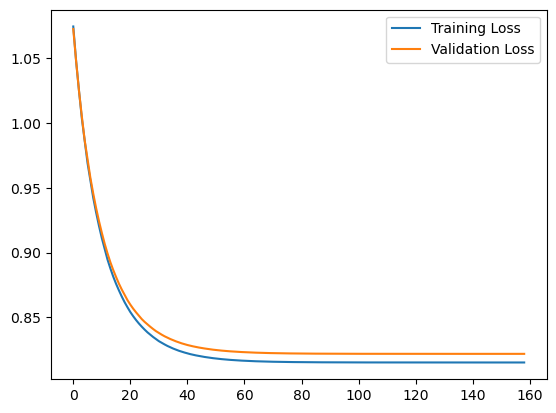

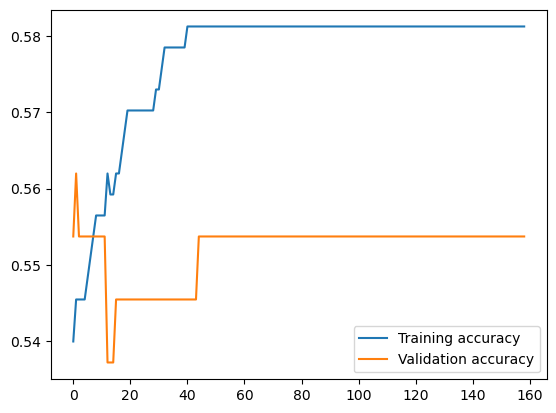

12/12 [==============================] - 0s 3ms/step
f1 score:  0.24752475247524755
[0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0
 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0
 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1
 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       186 |       131 |
+-----------+-----------+
|        21 |        25 |
+----

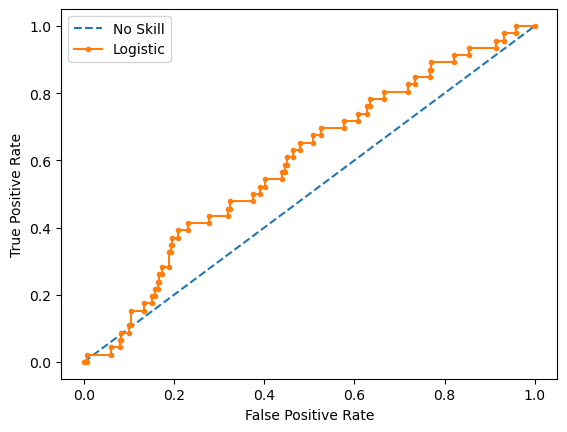

4/4 [==============================] - 0s 3ms/step
f1 score:  0.2285714285714286
[1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1
 1 0 1 1 1 1 0 0 1 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        59 |        47 |
+-----------+-----------+
|         7 |         8 |
+-----------+-----------+
0.5
0.5666666666666667


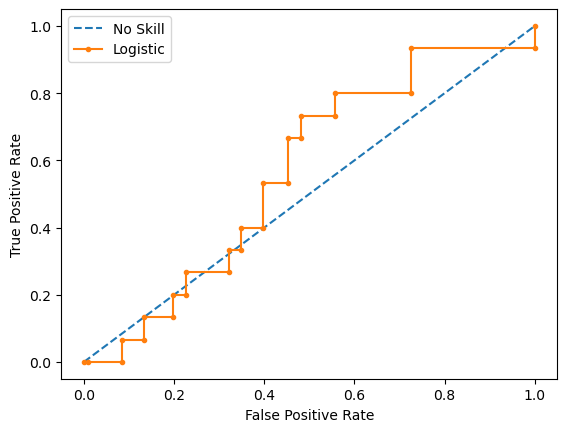

7/7 [==============================] - 0s 2ms/step
f1 score:  0.2047244094488189
[0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0
 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1
 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        95 |        88 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+
0.5
0.5582177385456074


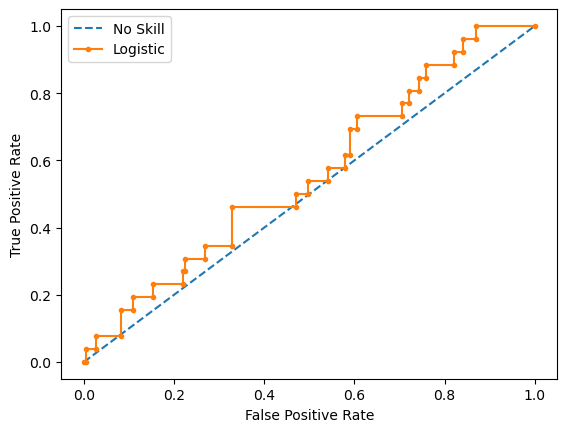

In [155]:
history_plotter(history_basic)
results(model_basic, X_train_pp, y_train_1)
results(model_basic, X_val_pp, y_val_1)
results(model_basic, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [156]:
# l1 0.01: all 0s
# l2 0.01: all 0s
# l1 0.001: as good as random guessing
# l2 0.001: as good as random guessing

## 2

In [175]:
model_2 = Sequential([
    Dense(10, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
    # LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_2.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [176]:
history_2 = model_2.fit(X_train_pp, y_train_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
12/12 [==============================] - 2s 49ms/step - loss: 2.2224 - accuracy: 0.6281 - val_loss: 2.1323 - val_accuracy: 0.5950
Epoch 2/600
12/12 [==============================] - 0s 11ms/step - loss: 2.0591 - accuracy: 0.6529 - val_loss: 2.0126 - val_accuracy: 0.6033
Epoch 3/600
12/12 [==============================] - 0s 11ms/step - loss: 1.9629 - accuracy: 0.6556 - val_loss: 1.9105 - val_accuracy: 0.6446
Epoch 4/600
12/12 [==============================] - 0s 11ms/step - loss: 1.8672 - accuracy: 0.6419 - val_loss: 1.8207 - val_accuracy: 0.6612
Epoch 5/600
12/12 [==============================] - 0s 9ms/step - loss: 1.7916 - accuracy: 0.6694 - val_loss: 1.7428 - val_accuracy: 0.6777
Epoch 6/600
12/12 [==============================] - 0s 9ms/step - loss: 1.7144 - accuracy: 0.6915 - val_loss: 1.6765 - val_accuracy: 0.6942
Epoch 7/600
12/12 [==============================] - 0s 9ms/step - loss: 1.6532 - accuracy: 0.7218 - val_loss: 1.6182 - val_accuracy: 0.7273
Epoch 8/6

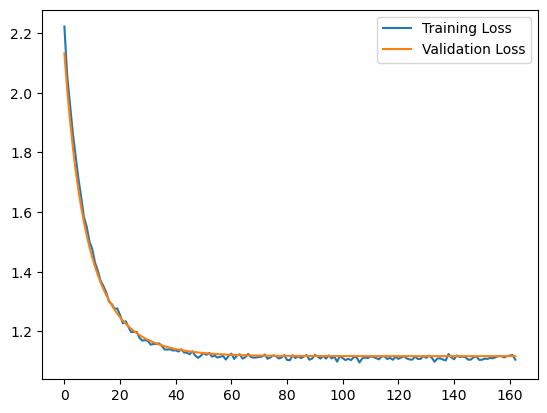

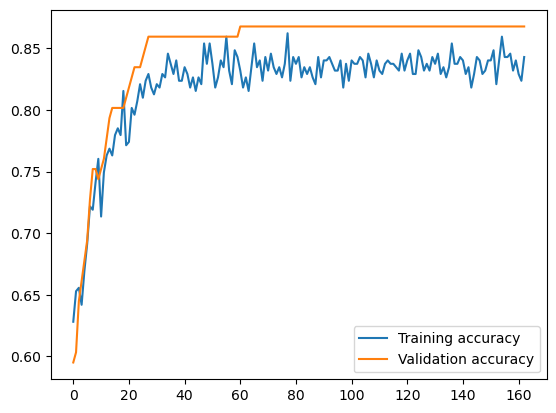

12/12 [==============================] - 0s 3ms/step
f1 score:  0.07272727272727274
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       310 |         7 |
+-----------+-----------+
|        44 |         2 |
+----

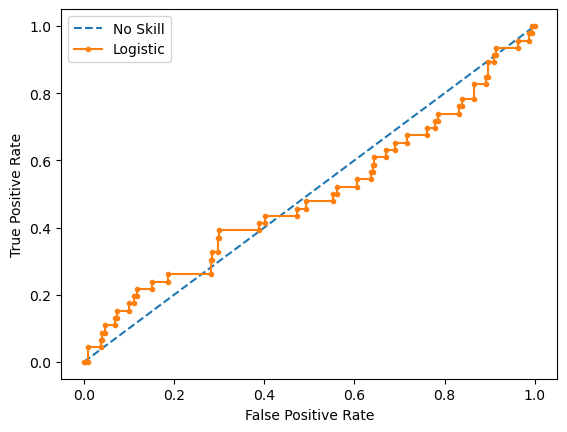

4/4 [==============================] - 0s 3ms/step
f1 score:  0.1111111111111111
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       104 |         2 |
+-----------+-----------+
|        14 |         1 |
+-----------+-----------+
0.5
0.3886792452830189


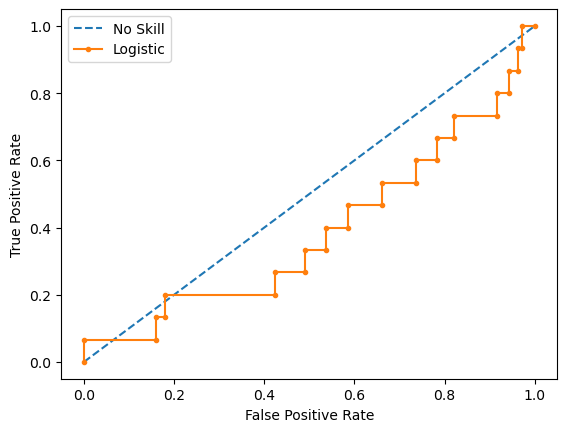

7/7 [==============================] - 0s 3ms/step
f1 score:  0.060606060606060615
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        25 |         1 |
+-----------+-----------+
0.5
0.38839848675914246


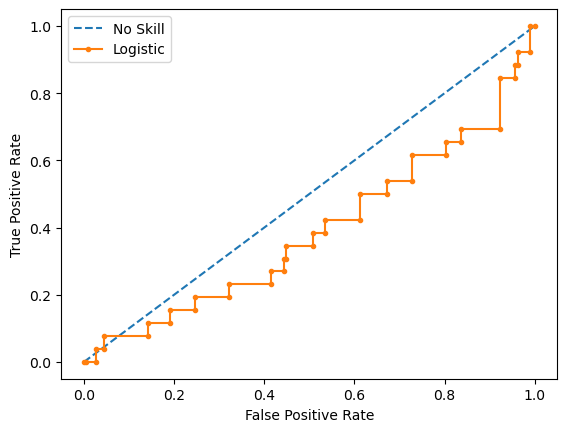

In [177]:
history_plotter(history_2)
results(model_2, X_train_pp, y_train_1)
results(model_2, X_val_pp, y_val_1)
results(model_2, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [181]:
# l1 0.01: all 0s
# l2 0.01: all 0s
# l1 0.001: as good as random guessing
# l2 0.001: as good as random guessing

## 3

In [189]:
model_3 = Sequential([
    Dense(10, input_shape = [X_train_1.shape[1]], kernel_regularizer=l1(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l1(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_3.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [190]:
history_3 = model_3.fit(X_train_pp, y_train_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
12/12 [==============================] - 3s 41ms/step - loss: 9.0174 - accuracy: 0.4904 - val_loss: 8.8001 - val_accuracy: 0.4463
Epoch 2/600
12/12 [==============================] - 0s 10ms/step - loss: 8.6060 - accuracy: 0.5344 - val_loss: 8.4136 - val_accuracy: 0.4711
Epoch 3/600
12/12 [==============================] - 0s 9ms/step - loss: 8.2392 - accuracy: 0.5317 - val_loss: 8.0679 - val_accuracy: 0.4793
Epoch 4/600
12/12 [==============================] - 0s 10ms/step - loss: 7.9138 - accuracy: 0.5399 - val_loss: 7.7583 - val_accuracy: 0.5207
Epoch 5/600
12/12 [==============================] - 0s 9ms/step - loss: 7.6259 - accuracy: 0.5895 - val_loss: 7.4822 - val_accuracy: 0.5124
Epoch 6/600
12/12 [==============================] - 0s 10ms/step - loss: 7.3646 - accuracy: 0.5895 - val_loss: 7.2380 - val_accuracy: 0.5455
Epoch 7/600
12/12 [==============================] - 0s 10ms/step - loss: 7.1191 - accuracy: 0.6501 - val_loss: 7.0166 - val_accuracy: 0.6033
Epoch 8/

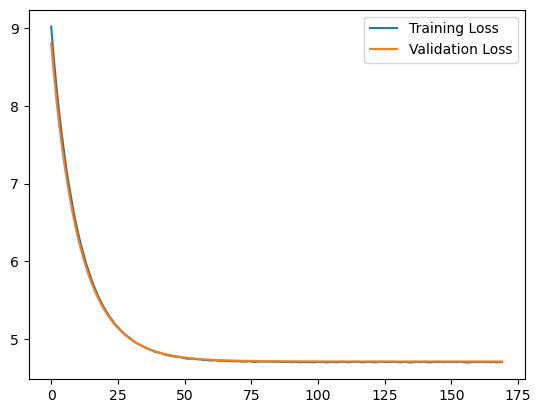

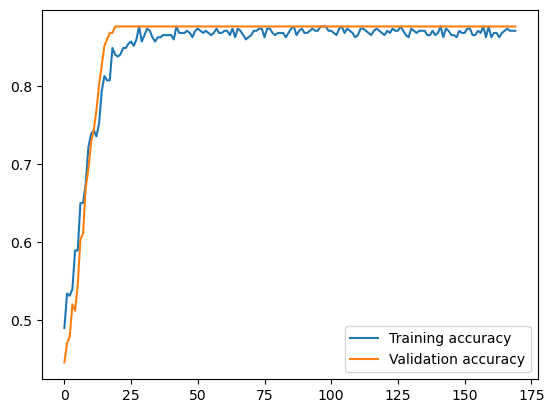

12/12 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       317 |         0 |
+-----------+-----------+
|        46 |         0 |
+-----------+--------

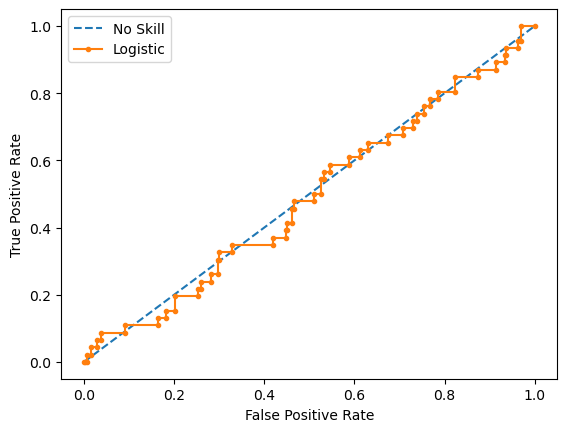

4/4 [==============================] - 0s 6ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       106 |         0 |
+-----------+-----------+
|        15 |         0 |
+-----------+-----------+
0.5
0.2742138364779874


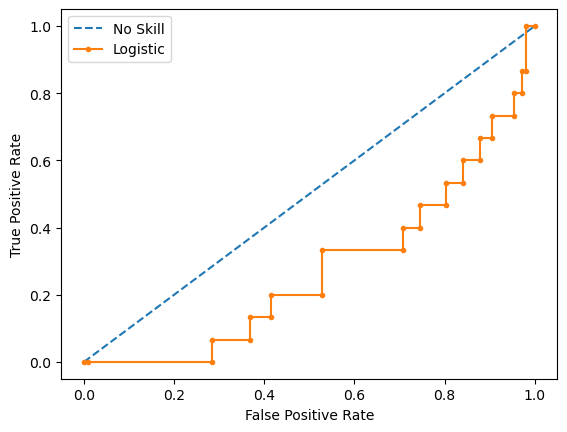

7/7 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.3720050441361917


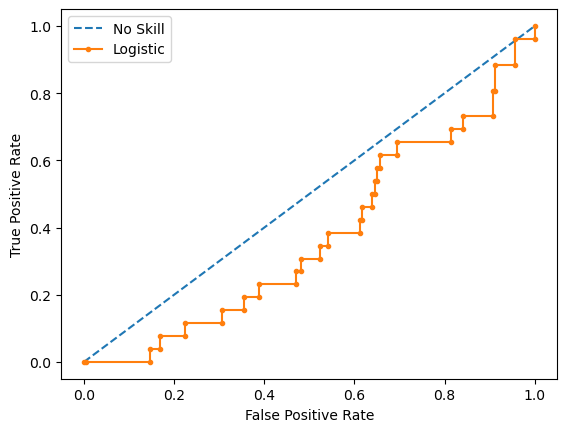

In [191]:
history_plotter(history_3)
results(model_3, X_train_pp, y_train_1)
results(model_3, X_val_pp, y_val_1)
results(model_3, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [192]:
# l1 0.01: all 0s
# l2 0.01: all 0s
# l1 0.001: all 0s
# l2 0.001: all 0s

## 4

In [207]:
model_4 = Sequential([
    Dense(256, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(256, kernel_regularizer=l1(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_4.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [208]:
history_4 = model_4.fit(X_train_pp, y_train_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
12/12 [==============================] - 3s 46ms/step - loss: 356.4409 - accuracy: 0.5620 - val_loss: 351.9042 - val_accuracy: 0.7438
Epoch 2/600
12/12 [==============================] - 0s 12ms/step - loss: 348.7216 - accuracy: 0.6171 - val_loss: 344.6472 - val_accuracy: 0.7934
Epoch 3/600
12/12 [==============================] - 0s 12ms/step - loss: 341.7102 - accuracy: 0.6501 - val_loss: 338.0035 - val_accuracy: 0.8264
Epoch 4/600
12/12 [==============================] - 0s 11ms/step - loss: 335.3398 - accuracy: 0.7052 - val_loss: 331.9253 - val_accuracy: 0.8430
Epoch 5/600
12/12 [==============================] - 0s 14ms/step - loss: 329.5486 - accuracy: 0.7410 - val_loss: 326.3634 - val_accuracy: 0.8430
Epoch 6/600
12/12 [==============================] - 0s 13ms/step - loss: 324.2437 - accuracy: 0.7383 - val_loss: 321.3981 - val_accuracy: 0.8430
Epoch 7/600
12/12 [==============================] - 0s 12ms/step - loss: 319.4015 - accuracy: 0.7466 - val_loss: 316.8394 -

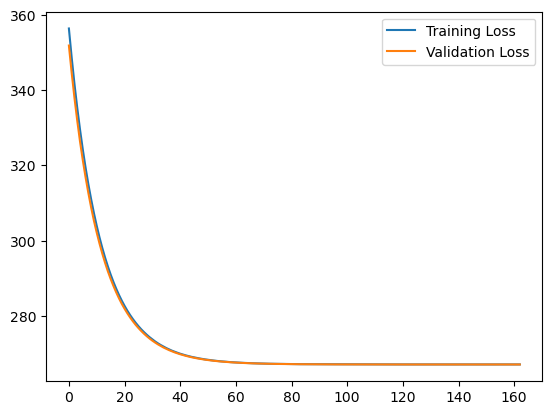

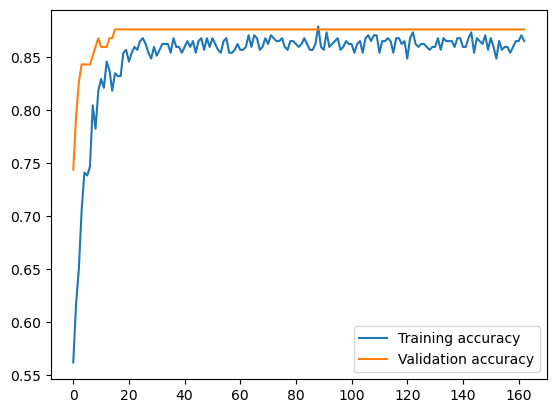

12/12 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       315 |         2 |
+-----------+-----------+
|        46 |         0 |
+-----------+--------

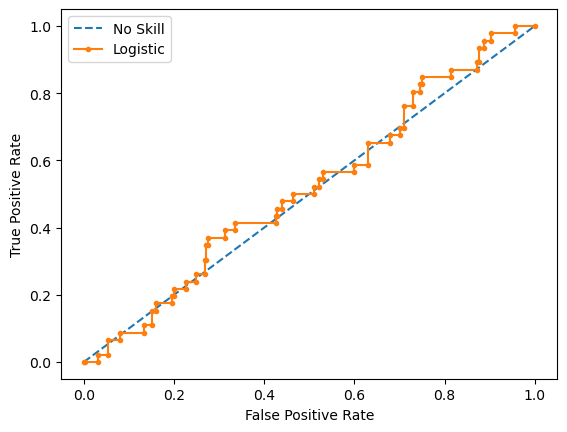

4/4 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       106 |         0 |
+-----------+-----------+
|        15 |         0 |
+-----------+-----------+
0.5
0.6389937106918239


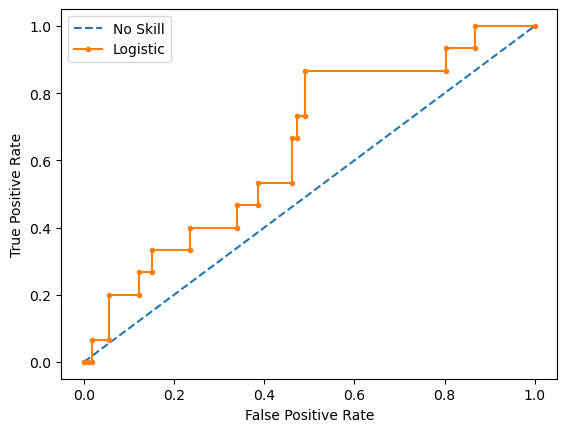

7/7 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.4728877679697352


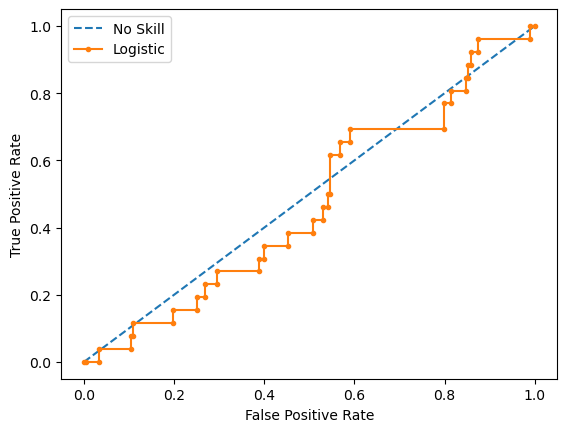

In [209]:
history_plotter(history_4)
results(model_4, X_train_pp, y_train_1)
results(model_4, X_val_pp, y_val_1)
results(model_4, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [211]:
# l1 0.01: all 0s
# l2 0.01: all 0s
# l1 0.001: all 0s
# l2 0.001: all 0s
# l2 0.0001: all 0s

## CONCLUSION: NORMAL DOES NOT WORK

# Oversampling

## Prep

In [213]:
oversampler = RandomOverSampler(random_state=42)
X_train_bal_1, y_train_bal_1 = oversampler.fit_resample(X_train_1, y_train_1)

In [214]:
X_train_pp, X_test_pp, X_val_pp = preprocessor(X_train_bal_1, X_test_1, X_val_1)

## 1

In [236]:
model_basic = Sequential([
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_basic.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [237]:
history_basic = model_basic.fit(X_train_pp, y_train_bal_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
20/20 [==============================] - 2s 26ms/step - loss: 1.0084 - accuracy: 0.5189 - val_loss: 0.9222 - val_accuracy: 0.5455
Epoch 2/600
20/20 [==============================] - 0s 6ms/step - loss: 0.9777 - accuracy: 0.5189 - val_loss: 0.8958 - val_accuracy: 0.5455
Epoch 3/600
20/20 [==============================] - 0s 6ms/step - loss: 0.9531 - accuracy: 0.5205 - val_loss: 0.8752 - val_accuracy: 0.5455
Epoch 4/600
20/20 [==============================] - 0s 7ms/step - loss: 0.9324 - accuracy: 0.5221 - val_loss: 0.8580 - val_accuracy: 0.5455
Epoch 5/600
20/20 [==============================] - 0s 6ms/step - loss: 0.9153 - accuracy: 0.5221 - val_loss: 0.8441 - val_accuracy: 0.5455
Epoch 6/600
20/20 [==============================] - 0s 7ms/step - loss: 0.9012 - accuracy: 0.5221 - val_loss: 0.8319 - val_accuracy: 0.5455
Epoch 7/600
20/20 [==============================] - 0s 7ms/step - loss: 0.8890 - accuracy: 0.5221 - val_loss: 0.8222 - val_accuracy: 0.5537
Epoch 8/600


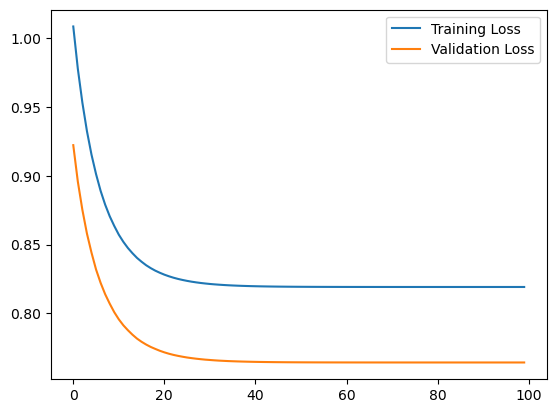

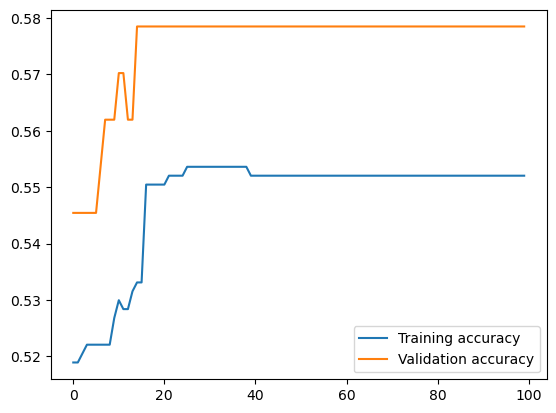

20/20 [==============================] - 0s 3ms/step
f1 score:  0.5657492354740062
[1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0
 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0
 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1
 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1
 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0
 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1
 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1
 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0
 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0
 1 0 0 1 0 0 0 1 

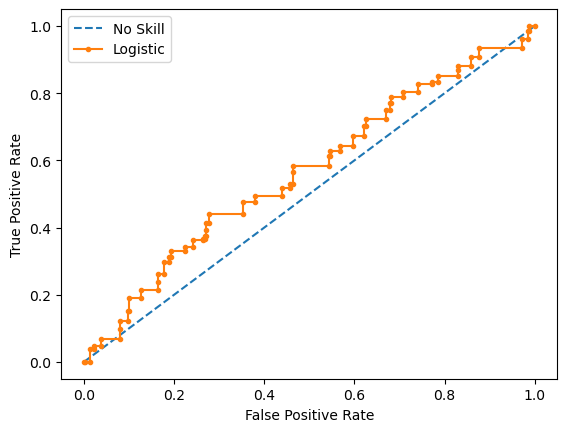

4/4 [==============================] - 0s 3ms/step
f1 score:  0.2153846153846154
[0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 1 0 0 0 1 0 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        63 |        43 |
+-----------+-----------+
|         8 |         7 |
+-----------+-----------+
0.5
0.5528301886792453


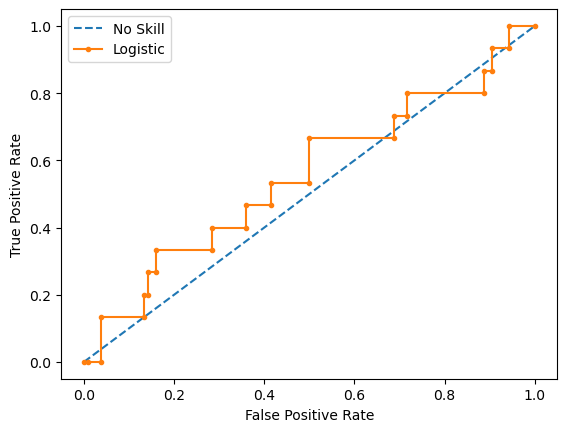

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3025210084033613
[1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0
 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0
 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       108 |        75 |
+-----------+-----------+
|         8 |        18 |
+-----------+-----------+
0.5
0.7065994115174444


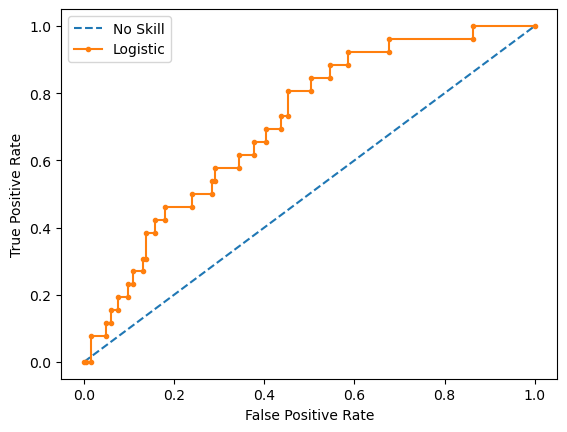

In [238]:
history_plotter(history_basic)
results(model_basic, X_train_pp, y_train_bal_1)
results(model_basic, X_val_pp, y_val_1)
results(model_basic, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [239]:
# l1 0.01: improvement
# l2 0.01: improvement (roughly the same performance)
# l1 0.1: not much difference
# l1 0.001: as good as random guessing
# l2 0.001: as good as random guessing, bit better than l1 maybe cuz of stochastic nature of training

## 2

In [284]:
model_2 = Sequential([
    Dense(500, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
    # LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_2.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [285]:
history_2 = model_2.fit(X_train_pp, y_train_bal_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
20/20 [==============================] - 2s 28ms/step - loss: 1.6840 - accuracy: 0.6136 - val_loss: 0.9519 - val_accuracy: 0.7438
Epoch 2/600
20/20 [==============================] - 0s 13ms/step - loss: 0.7868 - accuracy: 0.6136 - val_loss: 0.7247 - val_accuracy: 0.6612
Epoch 3/600
20/20 [==============================] - 0s 8ms/step - loss: 0.7085 - accuracy: 0.6672 - val_loss: 0.6930 - val_accuracy: 0.7273
Epoch 4/600
20/20 [==============================] - 0s 9ms/step - loss: 0.7052 - accuracy: 0.5915 - val_loss: 0.7221 - val_accuracy: 0.5289
Epoch 5/600
20/20 [==============================] - 0s 8ms/step - loss: 0.6988 - accuracy: 0.6199 - val_loss: 0.6885 - val_accuracy: 0.7190
Epoch 6/600
20/20 [==============================] - 0s 9ms/step - loss: 0.6961 - accuracy: 0.6293 - val_loss: 0.6758 - val_accuracy: 0.8099
Epoch 7/600
20/20 [==============================] - 0s 8ms/step - loss: 0.6948 - accuracy: 0.6562 - val_loss: 0.6964 - val_accuracy: 0.6612
Epoch 8/600

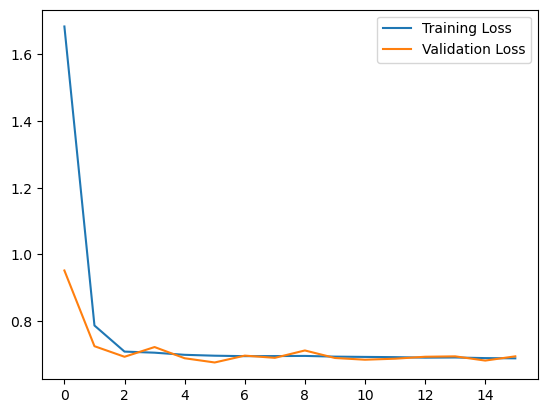

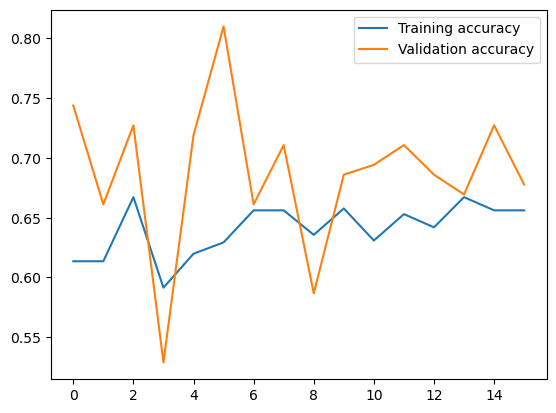

20/20 [==============================] - 0s 3ms/step
f1 score:  0.6221441124780316
[1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0
 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1
 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0
 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0
 1 0 0 0 0 0 0 0 

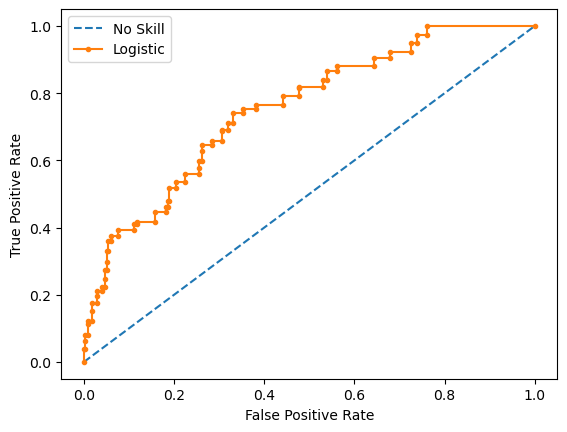

4/4 [==============================] - 0s 4ms/step
f1 score:  0.46511627906976744
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 1 0 1 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        88 |        18 |
+-----------+-----------+
|         5 |        10 |
+-----------+-----------+
0.5
0.7849056603773585


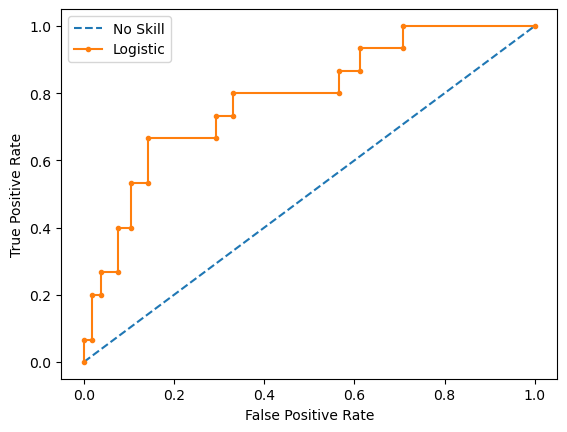

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3896103896103896
[0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       147 |        36 |
+-----------+-----------+
|        11 |        15 |
+-----------+-----------+
0.5
0.7175283732660782


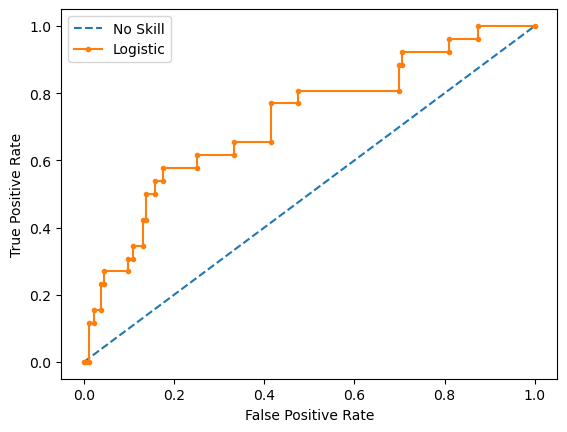

In [286]:
history_plotter(history_2)
results(model_2, X_train_pp, y_train_bal_1)
results(model_2, X_val_pp, y_val_1)
results(model_2, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [287]:
# l1 0.01: all 1s
# l2 0.01: okayish (= improvement)
# l1 0.1: all 1s
# l2 0.1: okayish
# l1 0.001: as good as random guessing
# l2 0.001: okayish, not bad not good
# increasing 1st layer neurons doesn't help much

## 3

In [345]:
model_3 = Sequential([
    Dense(256, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.3),
    Dense(256, kernel_regularizer=l2(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.3),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_3.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [346]:
history_3 = model_3.fit(X_train_pp, y_train_bal_1, epochs = 600, batch_size = 32, validation_data = [X_val_pp, y_val_1],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
20/20 [==============================] - 3s 29ms/step - loss: 24.4048 - accuracy: 0.5252 - val_loss: 18.2114 - val_accuracy: 0.6364
Epoch 2/600
20/20 [==============================] - 0s 10ms/step - loss: 14.4800 - accuracy: 0.6246 - val_loss: 11.0419 - val_accuracy: 0.7273
Epoch 3/600
20/20 [==============================] - 0s 10ms/step - loss: 8.9895 - accuracy: 0.6640 - val_loss: 7.0806 - val_accuracy: 0.6364
Epoch 4/600
20/20 [==============================] - 0s 9ms/step - loss: 5.9398 - accuracy: 0.6420 - val_loss: 4.8659 - val_accuracy: 0.5868
Epoch 5/600
20/20 [==============================] - 0s 12ms/step - loss: 4.1753 - accuracy: 0.6719 - val_loss: 3.5324 - val_accuracy: 0.5950
Epoch 6/600
20/20 [==============================] - 0s 10ms/step - loss: 3.1049 - accuracy: 0.6688 - val_loss: 2.7036 - val_accuracy: 0.5537
Epoch 7/600
20/20 [==============================] - 0s 9ms/step - loss: 2.4317 - accuracy: 0.6924 - val_loss: 2.1783 - val_accuracy: 0.5537
Epoc

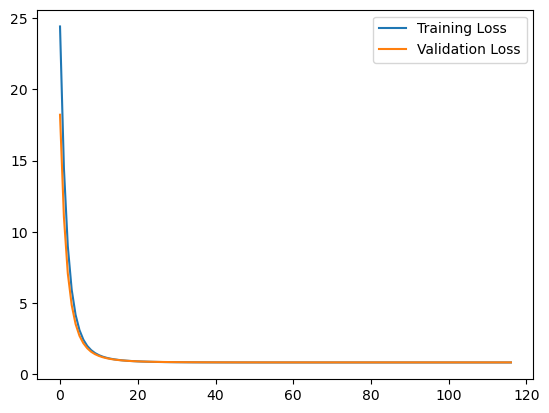

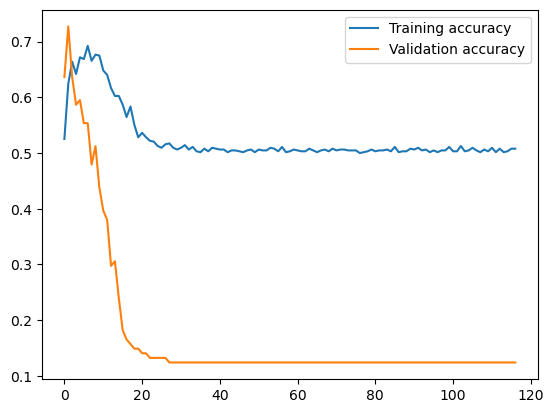

20/20 [==============================] - 0s 3ms/step
f1 score:  0.6666666666666666
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

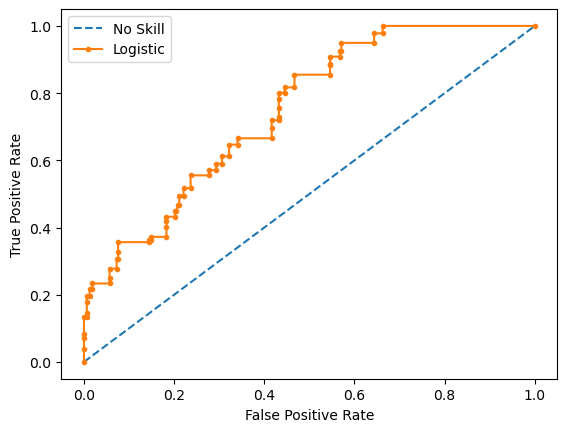

4/4 [==============================] - 0s 3ms/step
f1 score:  0.22058823529411764
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|         0 |       106 |
+-----------+-----------+
|         0 |        15 |
+-----------+-----------+
0.5
0.7062893081761007


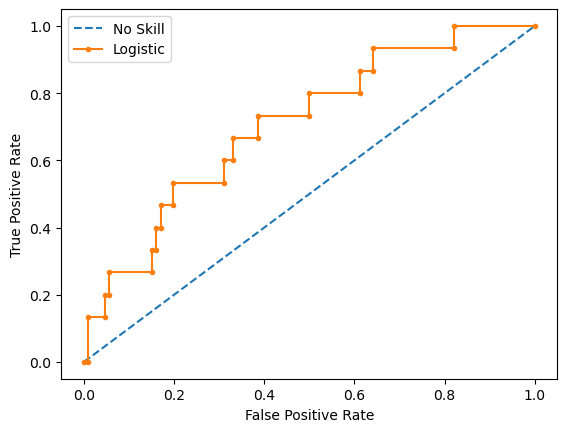

7/7 [==============================] - 0s 3ms/step
f1 score:  0.22127659574468084
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|         0 |       183 |
+-----------+-----------+
|         0 |        26 |
+-----------+-----------+
0.5
0.7011349306431274


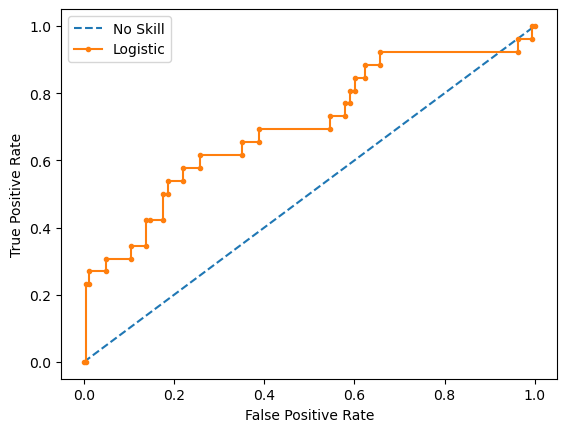

In [347]:
history_plotter(history_3)
results(model_3, X_train_pp, y_train_bal_1)
results(model_3, X_val_pp, y_val_1)
results(model_3, X_test_pp, y_t)
winsound.Beep(1000, 1000)

In [329]:
# (10, 10, 1)
# l1 0.1: all 0s
# l2 0.1: all 0s
# l1 0.01: all 1s
# l2 0.01: all 0s
# l1 0.001: not much better than random guessing
# l2 0.001: as good as random guessing
# l1 0.0001: as good as random guessing
# l2 0.0001: almost all 1s

## Either all 1s, or all 0s, or as good as random guessing

# StratifiedKFoldCV

## Prep

In [348]:
X_train = X_nt.copy()
y_train = y_nt.copy()
X_test = X_t.copy()
y_test = y_t.copy()

In [349]:
X_train['y_train'] = y_train
X_test['y_test'] = y_test
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [350]:
y_train = X_train.pop('y_train')
y_test = X_test.pop('y_test')

In [354]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)
kf = KFold(n_splits=n_splits)

## 1

In [400]:
def skfold_loop():
    f1_scores_df = pd.DataFrame(columns=['Fold', 'Train F1 Score', 'Validation F1 Score', 'Test F1 Score', 'Train AUC', 'Val AUC', 'Test AUC'])
    history_dict = {}
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f'Fold {fold + 1}/{n_splits}')
        # print(train_index)
        # # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
        # print(sum(y_train_fold)/len(y_train_fold), sum(y_val_fold)/len(y_val_fold), sum(y_test)/len(y_test))
        
        X_train_fold_pp, X_test_fold_pp, X_val_fold_pp = preprocessor(X_train_fold, X_test, X_val_fold)
        
        # print(len(X_train_fold_pp), len(X_val_fold_pp), len(y_train_fold), len(y_val_fold))
        # Create and train the model
        model = create_model()
        history = model.fit(X_train_fold_pp, y_train_fold, epochs=600, batch_size=32, validation_data=(X_val_fold_pp, y_val_fold),
                            callbacks = [early_stopping], class_weight=class_weight)
    
        # Evaluate the model on the validation set
        loss, accuracy = model.evaluate(X_val_fold_pp, y_val_fold)
        print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
        
        history_plotter(history)
        auc_train, f1_train = results(model, X_train_fold_pp, y_train_fold)
        auc_val, f1_val = results(model, X_val_fold_pp, y_val_fold)
        auc_test, f1_test = results(model, X_test_fold_pp, y_test)
    
        f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],
                                                              'Train F1 Score': [f1_train],
                                                              'Validation F1 Score': [f1_val],
                                                              'Test F1 Score': [f1_test],
                                                              'Train AUC': [auc_train],
                                                              'Val AUC': [auc_val],
                                                              'Test AUC': [auc_test]})], ignore_index=True)
    f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame(f1_scores_df.mean()).T], ignore_index=True)
    display(f1_scores_df)
    winsound.Beep(1000, 1000)

In [419]:
def create_model():
    model = Sequential([
        Dense(1, activation = 'sigmoid', kernel_regularizer=l1(0.1)) #, input_shape = [X_train_1.shape[1]]
    ])
    initial_lr = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
    model.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [422]:
# l1 0.1: okayish
# l2 0.1: okayish
# l1 0.01: okayish
# l2 0.01: okayish, bit better ig, but okayish isn't good enough!
# l1 0.001: worse than random guessing
# l2 0.001: worse than random guessing
# l1 0.0001: as good as random guessing
# l2 0.0001: as good as random guessing

Fold 1/5
Epoch 1/600
13/13 [==============================] - 1s 20ms/step - loss: 1.0503 - accuracy: 0.5891 - val_loss: 0.8795 - val_accuracy: 0.6392
Epoch 2/600
13/13 [==============================] - 0s 7ms/step - loss: 0.8722 - accuracy: 0.6357 - val_loss: 0.7605 - val_accuracy: 0.6907
Epoch 3/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7956 - accuracy: 0.6227 - val_loss: 0.7600 - val_accuracy: 0.6907
Epoch 4/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7810 - accuracy: 0.6537 - val_loss: 0.7583 - val_accuracy: 0.6289
Epoch 5/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7813 - accuracy: 0.6331 - val_loss: 0.7298 - val_accuracy: 0.6701
Epoch 6/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7674 - accuracy: 0.6848 - val_loss: 0.7663 - val_accuracy: 0.6082
Epoch 7/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7715 - accuracy: 0.6408 - val_loss: 0.7289 - val_accuracy: 0.7113
Epo

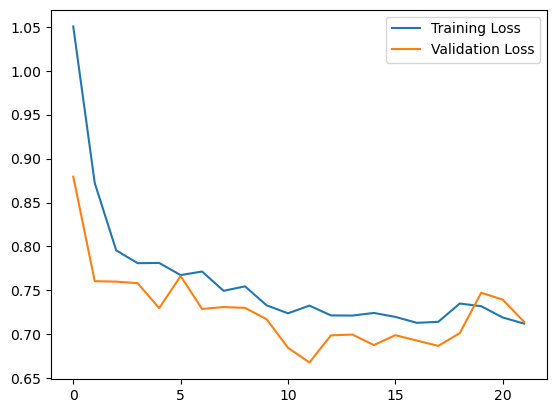

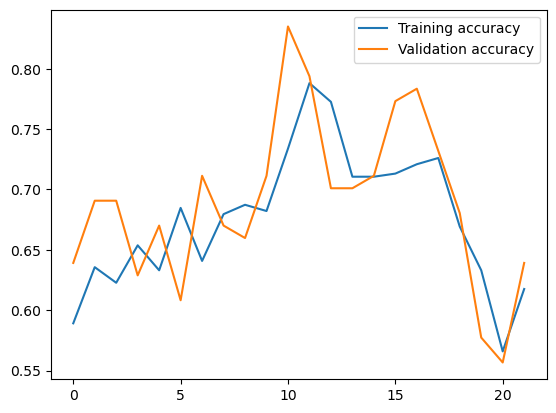

13/13 [==============================] - 0s 2ms/step
f1 score:  0.3652173913043478
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       293 |        45 |
+--------

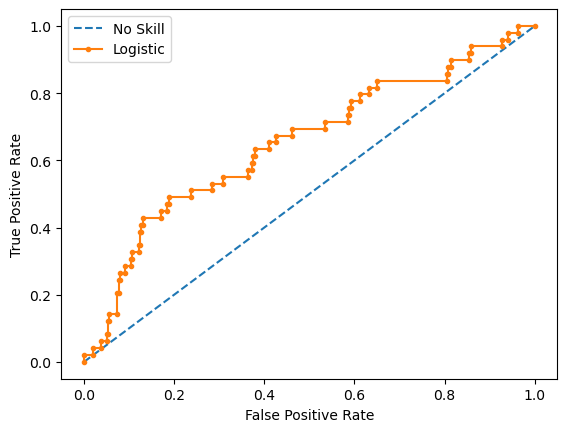

4/4 [==============================] - 0s 2ms/step
f1 score:  0.23076923076923075
[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        74 |        11 |
+-----------+-----------+
|         9 |         3 |
+-----------+-----------+
0.5
0.5990196078431372


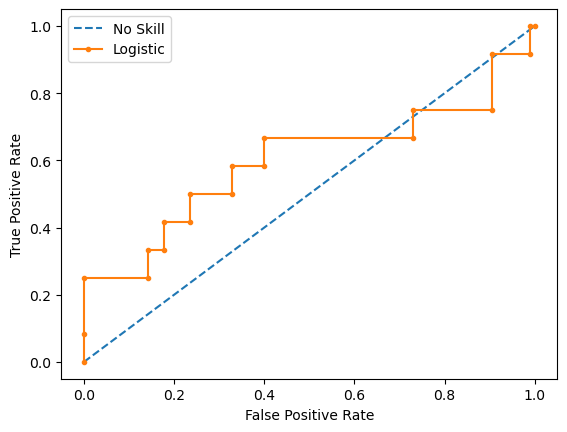

7/7 [==============================] - 0s 2ms/step
f1 score:  0.4333333333333333
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       162 |        21 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+
0.5
0.7765868011769651


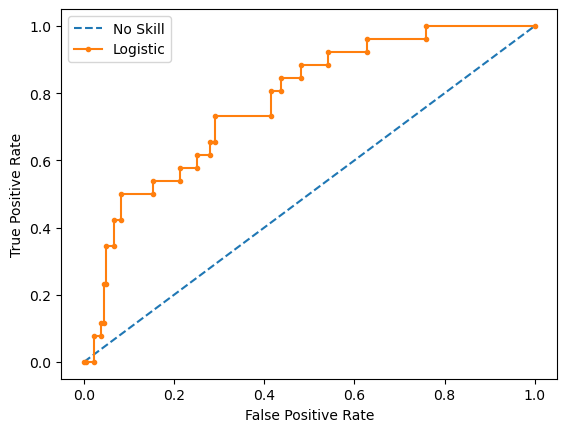

Fold 2/5
Epoch 1/600


C:\Users\aniru\AppData\Local\Temp\ipykernel_12464\705718930.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],


13/13 [==============================] - 1s 20ms/step - loss: 1.0035 - accuracy: 0.6382 - val_loss: 0.9097 - val_accuracy: 0.6392
Epoch 2/600
13/13 [==============================] - 0s 6ms/step - loss: 0.8450 - accuracy: 0.6796 - val_loss: 0.8004 - val_accuracy: 0.6289
Epoch 3/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7897 - accuracy: 0.6641 - val_loss: 0.7063 - val_accuracy: 0.7629
Epoch 4/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7634 - accuracy: 0.7106 - val_loss: 0.7491 - val_accuracy: 0.6082
Epoch 5/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7611 - accuracy: 0.6434 - val_loss: 0.7481 - val_accuracy: 0.6289
Epoch 6/600
13/13 [==============================] - 0s 6ms/step - loss: 0.8033 - accuracy: 0.6047 - val_loss: 0.7855 - val_accuracy: 0.6289
Epoch 7/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7706 - accuracy: 0.6124 - val_loss: 0.7848 - val_accuracy: 0.5876
Epoch 8/600
13/13 [=====

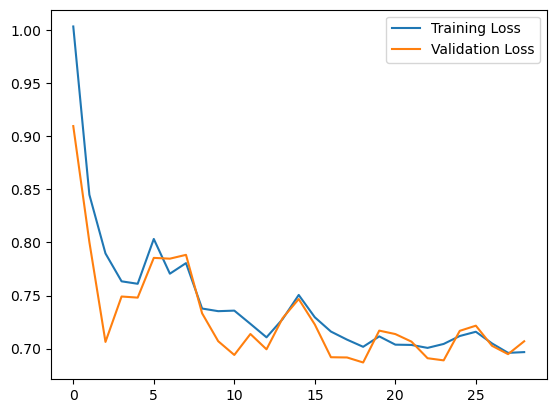

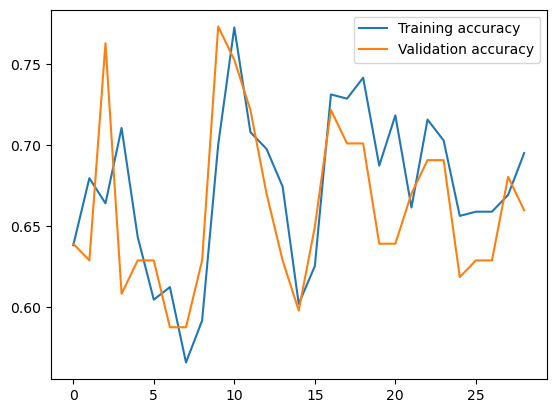

13/13 [==============================] - 0s 2ms/step
f1 score:  0.352112676056338
[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       270 |        68 |
+---------

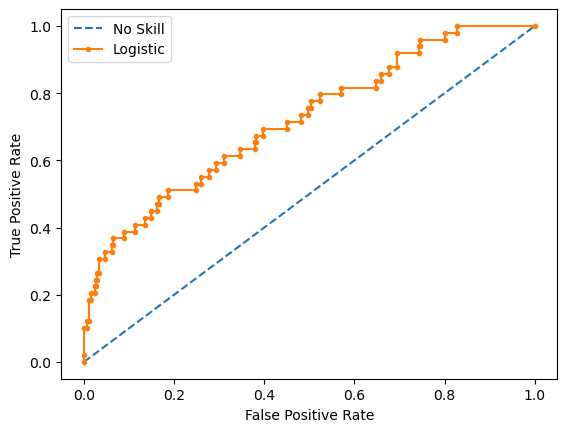

4/4 [==============================] - 0s 2ms/step
f1 score:  0.12121212121212123
[0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        66 |        19 |
+-----------+-----------+
|        10 |         2 |
+-----------+-----------+
0.5
0.6147058823529412


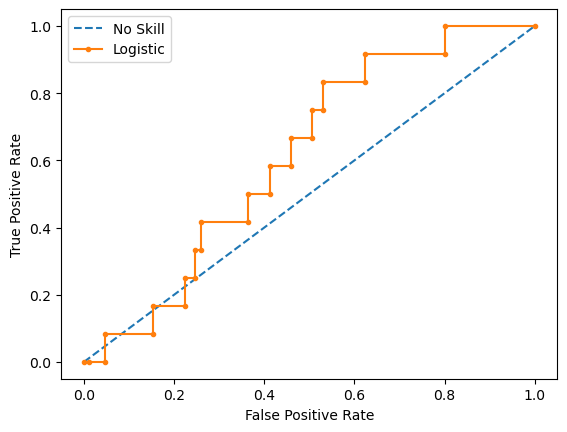

7/7 [==============================] - 0s 2ms/step
f1 score:  0.40963855421686746
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       143 |        40 |
+-----------+-----------+
|         9 |        17 |
+-----------+-----------+
0.5
0.7587221521647751


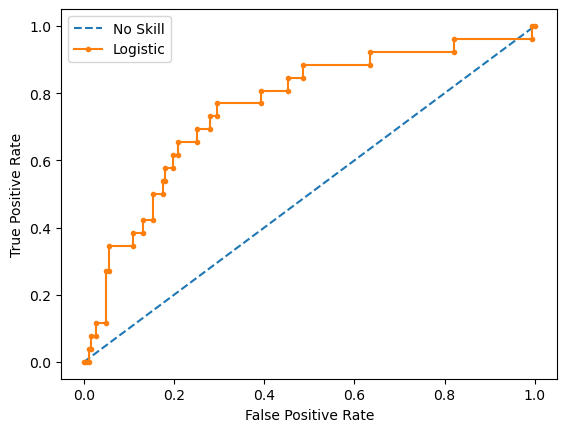

Fold 3/5
Epoch 1/600
13/13 [==============================] - 1s 20ms/step - loss: 1.0557 - accuracy: 0.4109 - val_loss: 0.9538 - val_accuracy: 0.5979
Epoch 2/600
13/13 [==============================] - 0s 5ms/step - loss: 0.8522 - accuracy: 0.6563 - val_loss: 0.6948 - val_accuracy: 0.7938
Epoch 3/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7882 - accuracy: 0.7933 - val_loss: 0.7257 - val_accuracy: 0.7320
Epoch 4/600
13/13 [==============================] - 0s 5ms/step - loss: 0.8057 - accuracy: 0.7158 - val_loss: 0.7477 - val_accuracy: 0.6598
Epoch 5/600
13/13 [==============================] - 0s 5ms/step - loss: 0.8127 - accuracy: 0.5426 - val_loss: 0.8600 - val_accuracy: 0.5155
Epoch 6/600
13/13 [==============================] - 0s 8ms/step - loss: 0.7720 - accuracy: 0.5969 - val_loss: 0.7586 - val_accuracy: 0.6598
Epoch 7/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7707 - accuracy: 0.6150 - val_loss: 0.7275 - val_accuracy: 0.6495
Epo

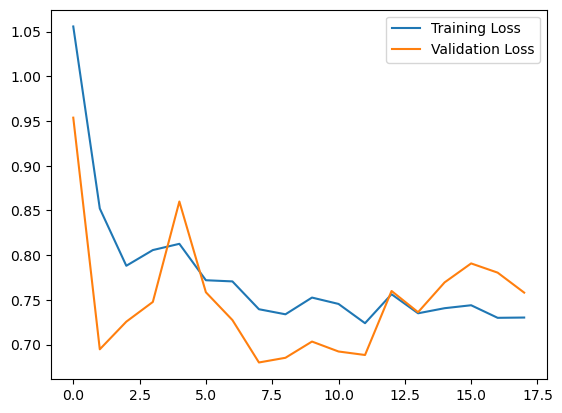

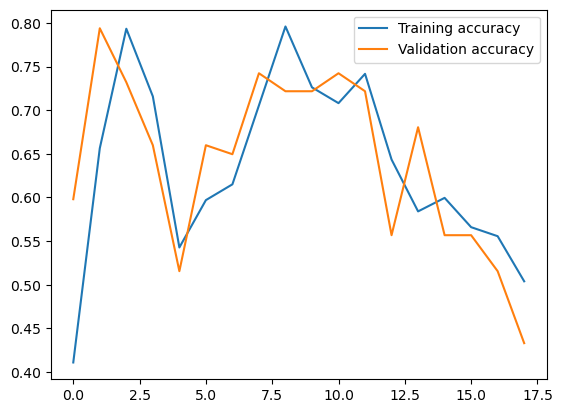

13/13 [==============================] - 0s 2ms/step
f1 score:  0.32394366197183094
[0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       268 |        70 |
+-------

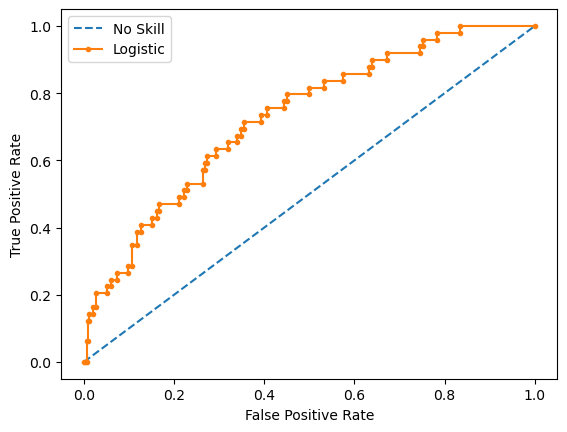

4/4 [==============================] - 0s 3ms/step
f1 score:  0.2857142857142857
[1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        67 |        18 |
+-----------+-----------+
|         7 |         5 |
+-----------+-----------+
0.5
0.6450980392156862


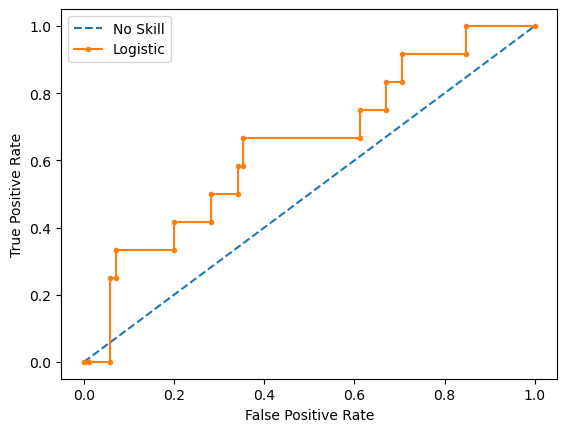

7/7 [==============================] - 0s 3ms/step
f1 score:  0.2465753424657534
[0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       145 |        38 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+
0.5
0.7097519966372425


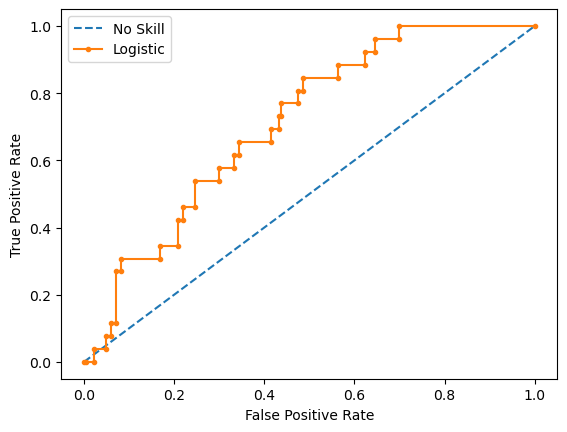

Fold 4/5
Epoch 1/600
13/13 [==============================] - 1s 19ms/step - loss: 1.0407 - accuracy: 0.4910 - val_loss: 1.0795 - val_accuracy: 0.5670
Epoch 2/600
13/13 [==============================] - 0s 5ms/step - loss: 0.9231 - accuracy: 0.5659 - val_loss: 0.9123 - val_accuracy: 0.6082
Epoch 3/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7887 - accuracy: 0.6667 - val_loss: 0.7618 - val_accuracy: 0.6289
Epoch 4/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7771 - accuracy: 0.7442 - val_loss: 0.7239 - val_accuracy: 0.7113
Epoch 5/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7531 - accuracy: 0.7855 - val_loss: 0.7267 - val_accuracy: 0.6701
Epoch 6/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7381 - accuracy: 0.7519 - val_loss: 0.7627 - val_accuracy: 0.6082
Epoch 7/600
13/13 [==============================] - 0s 6ms/step - loss: 0.7544 - accuracy: 0.6563 - val_loss: 0.7840 - val_accuracy: 0.6392
Epo

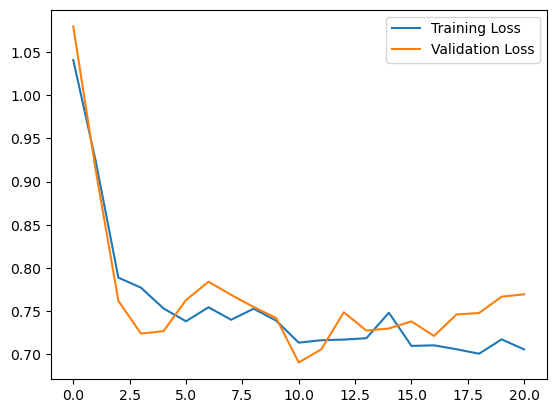

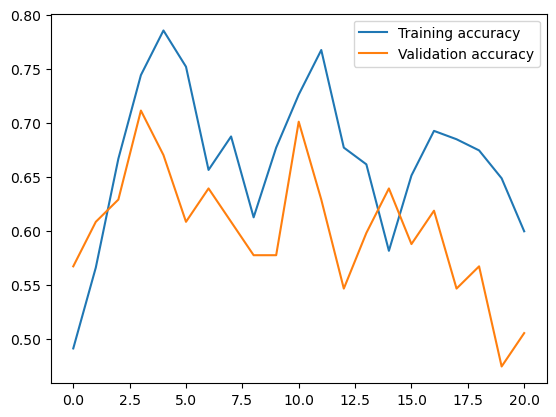

13/13 [==============================] - 0s 2ms/step
f1 score:  0.33333333333333337
[0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       287 |        52 |
+-------

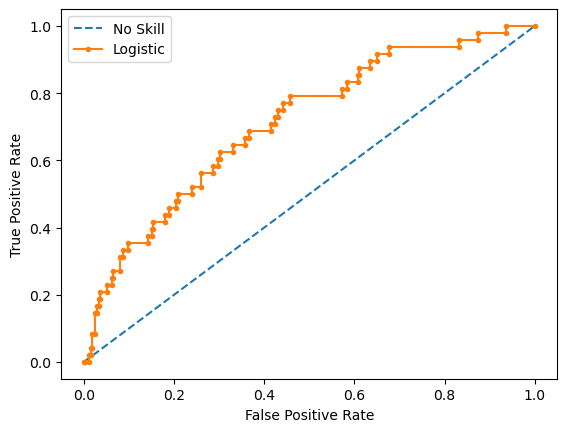

4/4 [==============================] - 0s 2ms/step
f1 score:  0.12121212121212123
[0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        66 |        18 |
+-----------+-----------+
|        11 |         2 |
+-----------+-----------+
0.5
0.5155677655677655


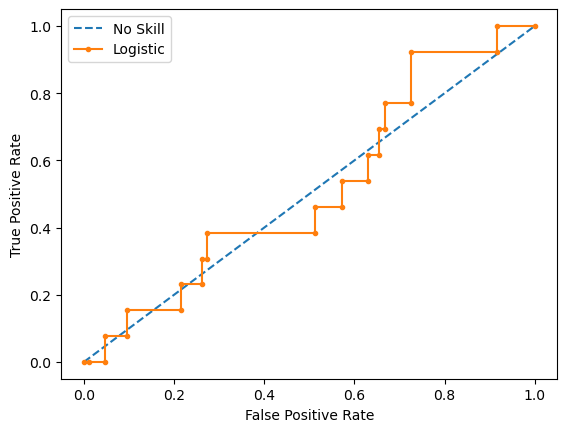

7/7 [==============================] - 0s 3ms/step
f1 score:  0.26666666666666666
[0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       157 |        26 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+
0.5
0.717948717948718


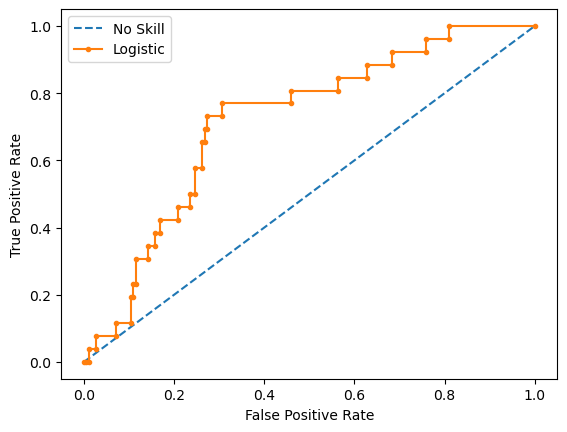

Fold 5/5
Epoch 1/600
13/13 [==============================] - 1s 19ms/step - loss: 0.9870 - accuracy: 0.4820 - val_loss: 0.8774 - val_accuracy: 0.5625
Epoch 2/600
13/13 [==============================] - 0s 5ms/step - loss: 0.8204 - accuracy: 0.5979 - val_loss: 0.7587 - val_accuracy: 0.6354
Epoch 3/600
13/13 [==============================] - 0s 5ms/step - loss: 0.8406 - accuracy: 0.5799 - val_loss: 0.8472 - val_accuracy: 0.5312
Epoch 4/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7890 - accuracy: 0.5928 - val_loss: 0.7163 - val_accuracy: 0.6458
Epoch 5/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7989 - accuracy: 0.5593 - val_loss: 0.7561 - val_accuracy: 0.6354
Epoch 6/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7553 - accuracy: 0.5567 - val_loss: 0.7425 - val_accuracy: 0.6146
Epoch 7/600
13/13 [==============================] - 0s 5ms/step - loss: 0.7712 - accuracy: 0.5490 - val_loss: 0.7515 - val_accuracy: 0.6146
Epo

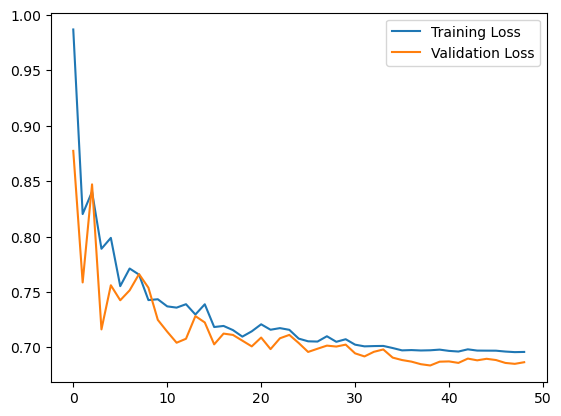

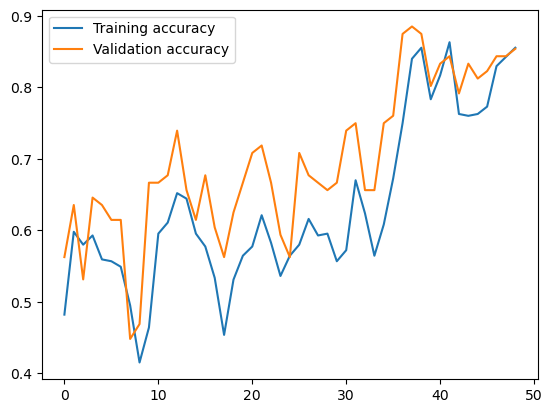

13/13 [==============================] - 0s 3ms/step
f1 score:  0.3055555555555556
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       327 |        12 |
+------

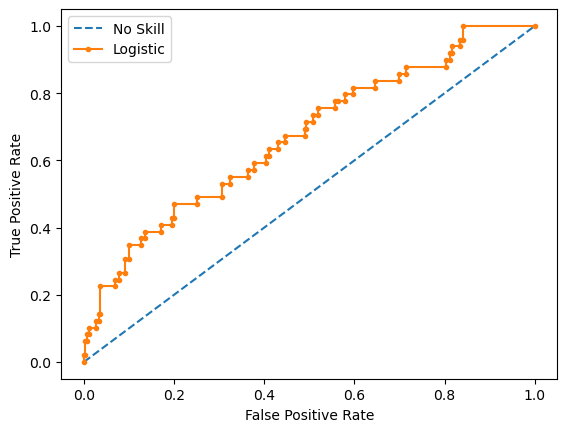

3/3 [==============================] - 0s 3ms/step
f1 score:  0.25
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        82 |         2 |
+-----------+-----------+
|        10 |         2 |
+-----------+-----------+
0.5
0.7976190476190477


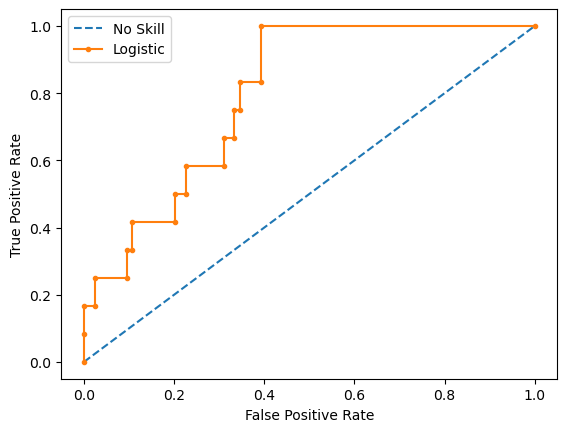

7/7 [==============================] - 0s 2ms/step
f1 score:  0.41860465116279066
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+
0.5
0.7770071458596048


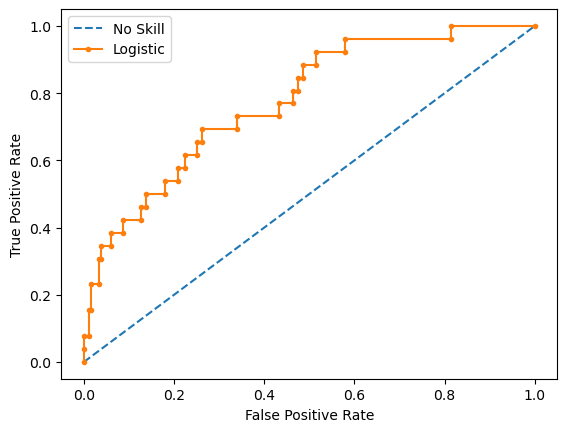

Fold Train F1 Score Validation F1 Score Test F1 Score Train AUC   Val AUC  \
0    1       0.365217            0.230769      0.433333  0.653363   0.59902   
1    2       0.352113            0.121212      0.409639  0.718573  0.614706   
2    3       0.323944            0.285714      0.246575  0.728233  0.645098   
3    4       0.333333            0.121212      0.266667  0.712144  0.515568   
4    5       0.305556                0.25      0.418605  0.670459  0.797619   
5  3.0       0.336033            0.201782      0.354964  0.696554  0.634402   

   Test AUC  
0  0.776587  
1  0.758722  
2  0.709752  
3  0.717949  
4  0.777007  
5  0.748003

In [421]:
skfold_loop()

## 2

In [526]:
def create_model():
    model = Sequential([
        Dense(100, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.1)), #activation = 'relu',
        LeakyReLU(alpha = 0.1),
        # BatchNormalization(),
        Dropout(0.2),
        # Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
        # LeakyReLU(alpha = 0.1),
        # BatchNormalization(),
        # Dropout(0.3),
        # Dense(6),
        Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
    ])
    initial_lr = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
    model.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}

Fold 1/5
Epoch 1/600
13/13 [==============================] - 2s 37ms/step - loss: 2.5196 - accuracy: 0.5659 - val_loss: 1.7571 - val_accuracy: 0.2165
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.2646 - accuracy: 0.6072 - val_loss: 1.0275 - val_accuracy: 0.4021
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 0.8916 - accuracy: 0.7907 - val_loss: 0.7840 - val_accuracy: 0.8351
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7670 - accuracy: 0.5711 - val_loss: 0.7360 - val_accuracy: 0.5670
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7273 - accuracy: 0.8165 - val_loss: 0.6812 - val_accuracy: 0.8763
Epoch 6/600
13/13 [==============================] - 0s 11ms/step - loss: 0.7113 - accuracy: 0.7907 - val_loss: 0.7219 - val_accuracy: 0.3505
Epoch 7/600
13/13 [==============================] - 0s 9ms/step - loss: 0.7498 - accuracy: 0.3256 - val_loss: 0.7031 - val_accuracy: 0.855

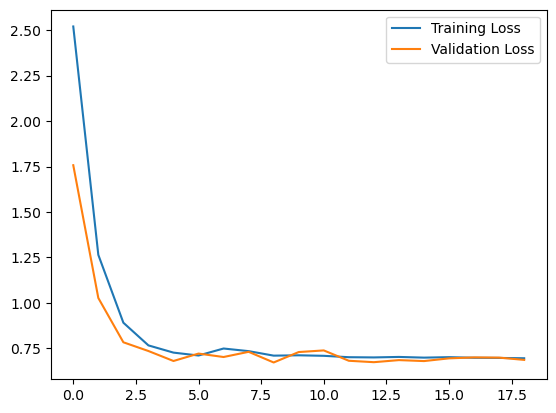

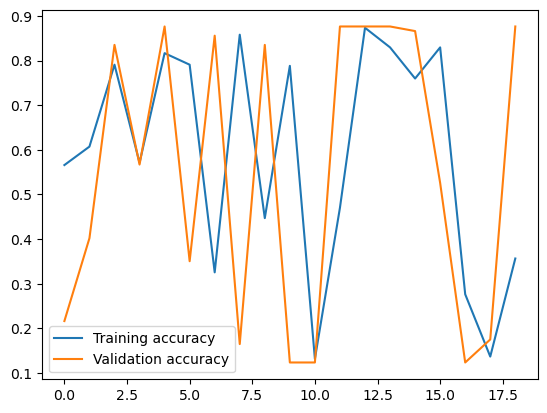

13/13 [==============================] - 0s 3ms/step
f1 score:  0.26666666666666666
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       322 |        16 |
+-------

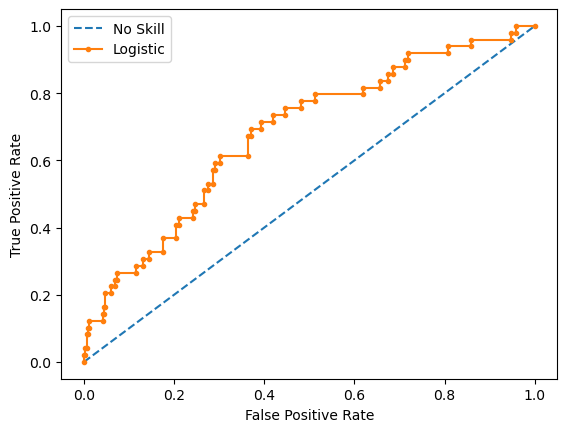

4/4 [==============================] - 0s 4ms/step
f1 score:  0.2
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        79 |         6 |
+-----------+-----------+
|        10 |         2 |
+-----------+-----------+
0.5
0.5745098039215687


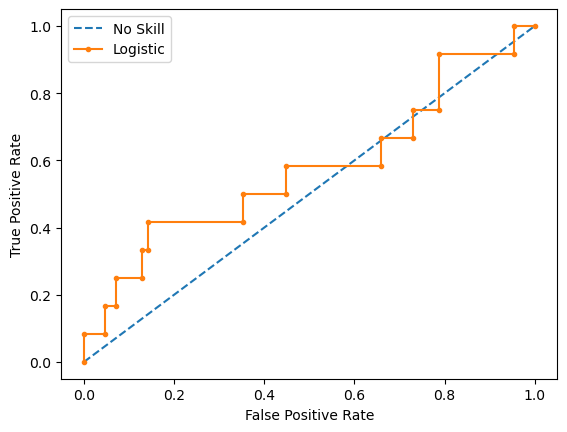

7/7 [==============================] - 0s 3ms/step
f1 score:  0.20512820512820515
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+
0.5
0.7158469945355193


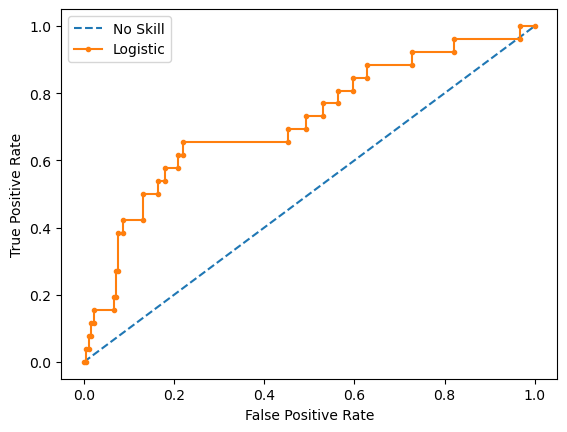

C:\Users\aniru\AppData\Local\Temp\ipykernel_12464\705718930.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],


Fold 2/5
Epoch 1/600
13/13 [==============================] - 5s 40ms/step - loss: 2.5188 - accuracy: 0.4160 - val_loss: 1.5730 - val_accuracy: 0.3299
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.1996 - accuracy: 0.7054 - val_loss: 0.9337 - val_accuracy: 0.7835
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 0.8931 - accuracy: 0.6822 - val_loss: 0.7669 - val_accuracy: 0.7835
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7720 - accuracy: 0.6460 - val_loss: 0.7944 - val_accuracy: 0.5464
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7938 - accuracy: 0.5762 - val_loss: 0.7324 - val_accuracy: 0.6907
Epoch 6/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7362 - accuracy: 0.7390 - val_loss: 0.7904 - val_accuracy: 0.3299
Epoch 7/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7494 - accuracy: 0.3928 - val_loss: 0.7456 - val_accuracy: 0.60

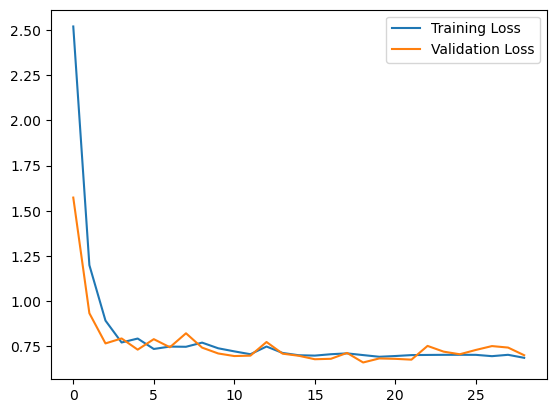

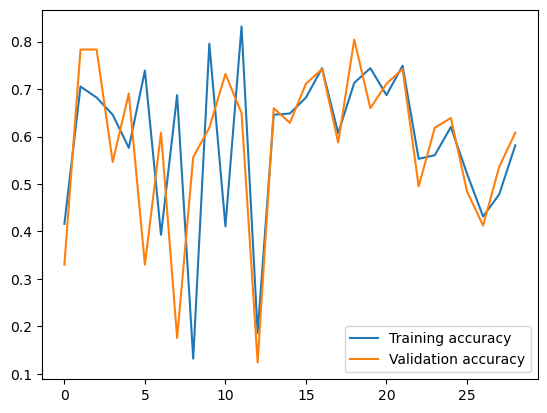

13/13 [==============================] - 0s 3ms/step
f1 score:  0.411214953271028
[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       302 |        36 |
+---------

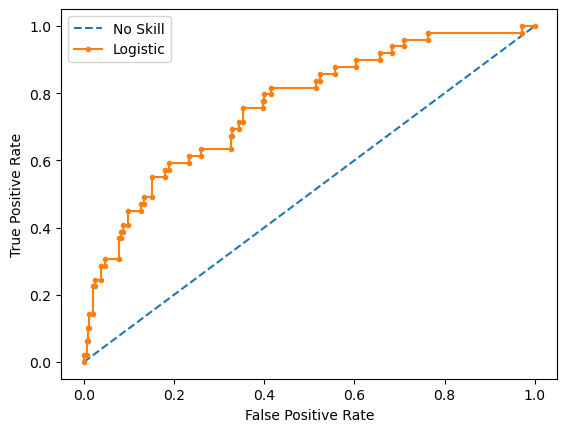

4/4 [==============================] - 0s 3ms/step
f1 score:  0.17391304347826086
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        76 |         9 |
+-----------+-----------+
|        10 |         2 |
+-----------+-----------+
0.5
0.6372549019607843


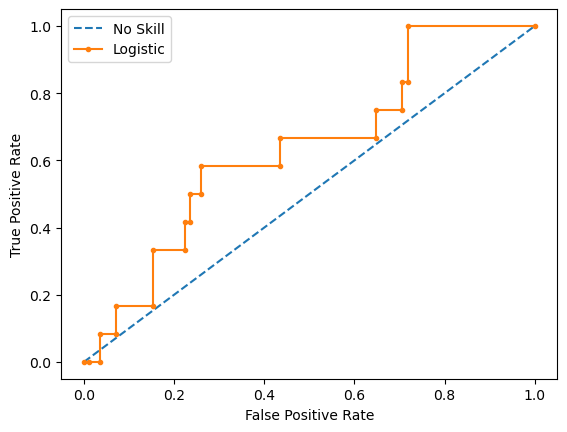

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3773584905660377
[0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       166 |        17 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+
0.5
0.7711223203026482


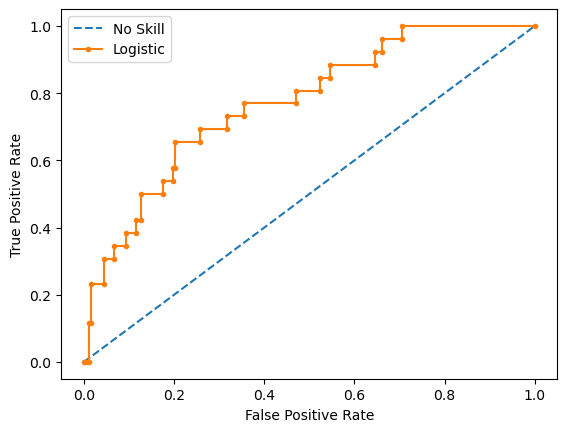

Fold 3/5
Epoch 1/600
13/13 [==============================] - 2s 40ms/step - loss: 2.2594 - accuracy: 0.5039 - val_loss: 1.3801 - val_accuracy: 0.8660
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.2744 - accuracy: 0.5039 - val_loss: 0.8692 - val_accuracy: 0.8866
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 0.9680 - accuracy: 0.6563 - val_loss: 0.9178 - val_accuracy: 0.1340
Epoch 4/600
13/13 [==============================] - 0s 9ms/step - loss: 0.8020 - accuracy: 0.6537 - val_loss: 0.7285 - val_accuracy: 0.8351
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7529 - accuracy: 0.3876 - val_loss: 0.7387 - val_accuracy: 0.6392
Epoch 6/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7550 - accuracy: 0.4522 - val_loss: 0.8400 - val_accuracy: 0.1753
Epoch 7/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7390 - accuracy: 0.5220 - val_loss: 0.6514 - val_accuracy: 0.876

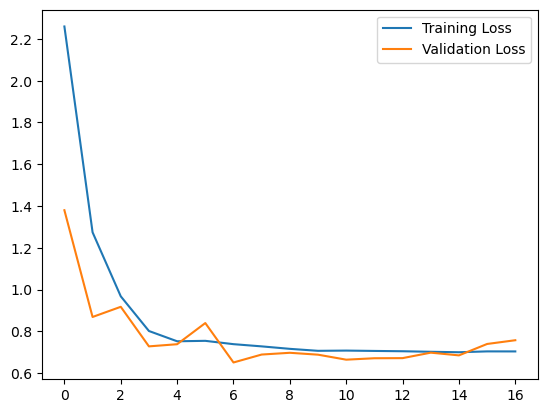

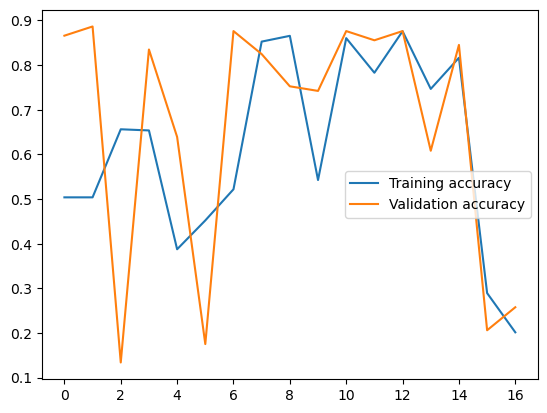

13/13 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       336 |         2 |
+-----------+-----------

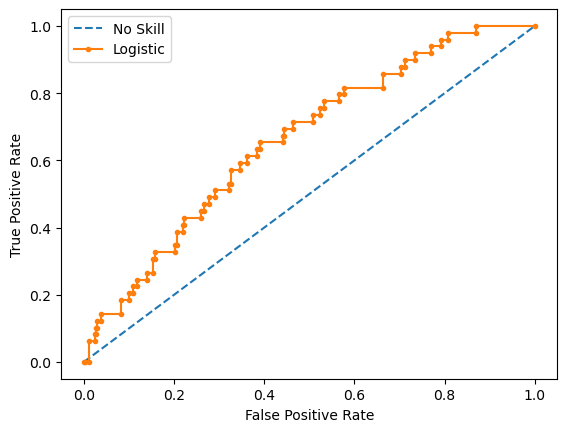

4/4 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        85 |         0 |
+-----------+-----------+
|        12 |         0 |
+-----------+-----------+
0.5
0.4852941176470588


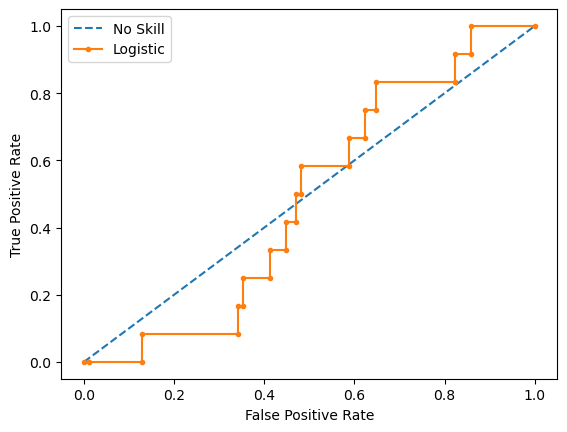

7/7 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.57145859604876


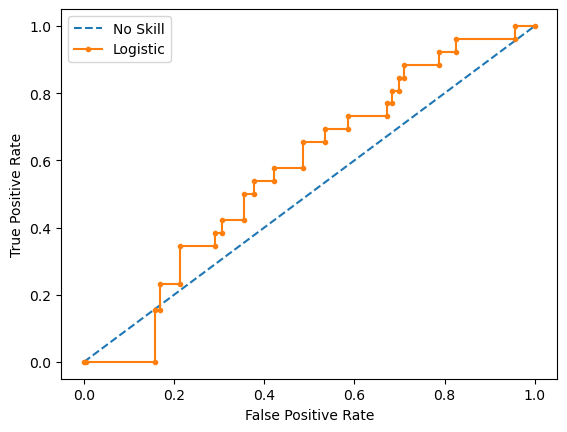

Fold 4/5
Epoch 1/600
13/13 [==============================] - 2s 38ms/step - loss: 2.4063 - accuracy: 0.4625 - val_loss: 1.4213 - val_accuracy: 0.8454
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3477 - accuracy: 0.5220 - val_loss: 1.1304 - val_accuracy: 0.2268
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 0.9084 - accuracy: 0.6176 - val_loss: 0.7951 - val_accuracy: 0.6804
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 0.8055 - accuracy: 0.7339 - val_loss: 0.6939 - val_accuracy: 0.8454
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7374 - accuracy: 0.8682 - val_loss: 0.6859 - val_accuracy: 0.8247
Epoch 6/600
13/13 [==============================] - 0s 10ms/step - loss: 0.7140 - accuracy: 0.8217 - val_loss: 0.6932 - val_accuracy: 0.7320
Epoch 7/600
13/13 [==============================] - 0s 9ms/step - loss: 0.7258 - accuracy: 0.4729 - val_loss: 0.7302 - val_accuracy: 0.484

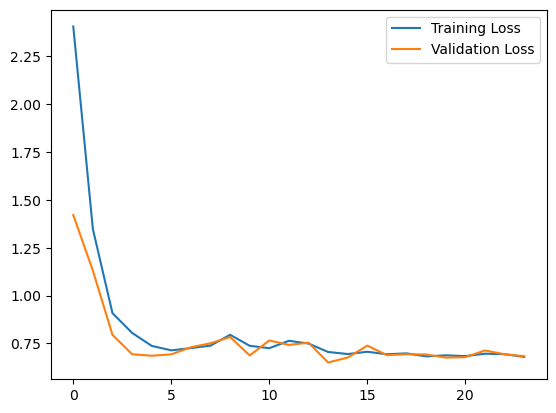

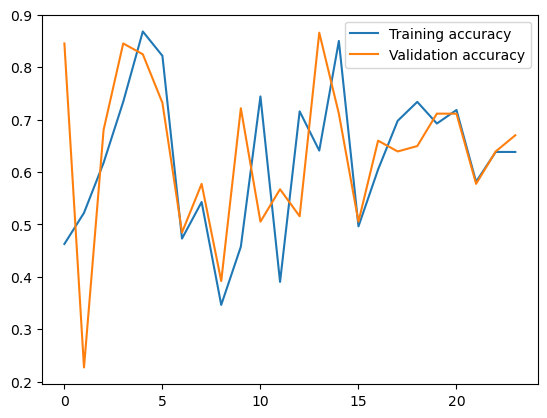

13/13 [==============================] - 0s 3ms/step
f1 score:  0.10344827586206896
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       332 |         7 |
+-------

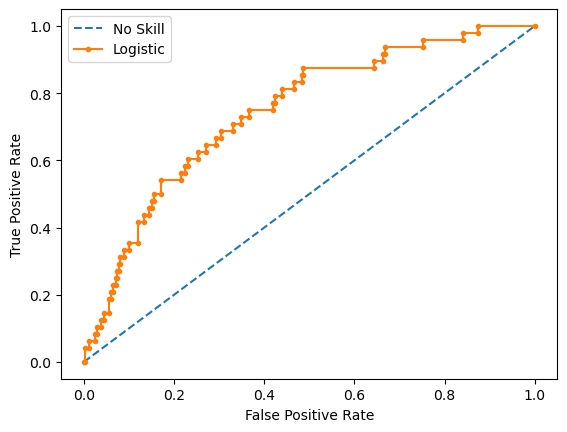

4/4 [==============================] - 0s 4ms/step
f1 score:  0.13333333333333336
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        83 |         1 |
+-----------+-----------+
|        12 |         1 |
+-----------+-----------+
0.5
0.4807692307692308


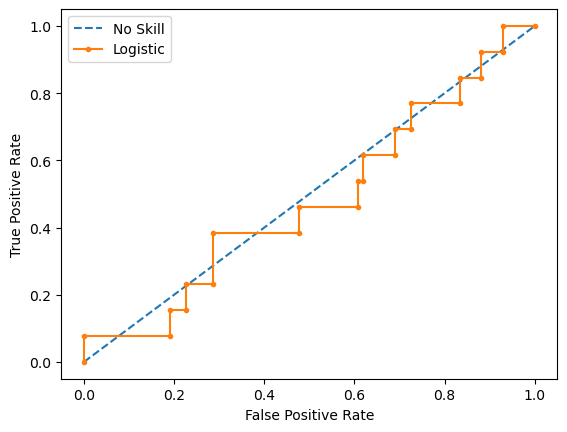

7/7 [==============================] - 0s 4ms/step
f1 score:  0.1764705882352941
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+
0.5
0.6849516603614965


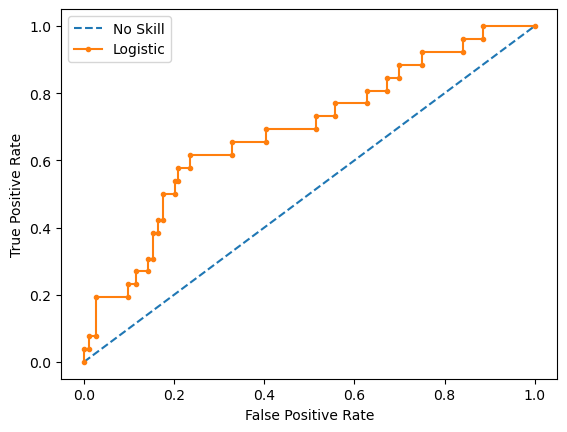

Fold 5/5
Epoch 1/600
13/13 [==============================] - 2s 38ms/step - loss: 2.1189 - accuracy: 0.5052 - val_loss: 1.2336 - val_accuracy: 0.8854
Epoch 2/600
13/13 [==============================] - 0s 14ms/step - loss: 1.1471 - accuracy: 0.5000 - val_loss: 0.9266 - val_accuracy: 0.6771
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 0.9680 - accuracy: 0.6727 - val_loss: 0.9475 - val_accuracy: 0.1250
Epoch 4/600
13/13 [==============================] - 0s 9ms/step - loss: 0.8006 - accuracy: 0.4716 - val_loss: 0.7151 - val_accuracy: 0.8646
Epoch 5/600
13/13 [==============================] - 0s 9ms/step - loss: 0.7566 - accuracy: 0.2809 - val_loss: 0.8042 - val_accuracy: 0.1250
Epoch 6/600
13/13 [==============================] - 0s 9ms/step - loss: 0.7603 - accuracy: 0.1418 - val_loss: 0.7505 - val_accuracy: 0.4583
Epoch 7/600
13/13 [==============================] - 0s 9ms/step - loss: 0.7399 - accuracy: 0.4356 - val_loss: 0.7643 - val_accuracy: 0.1250
E

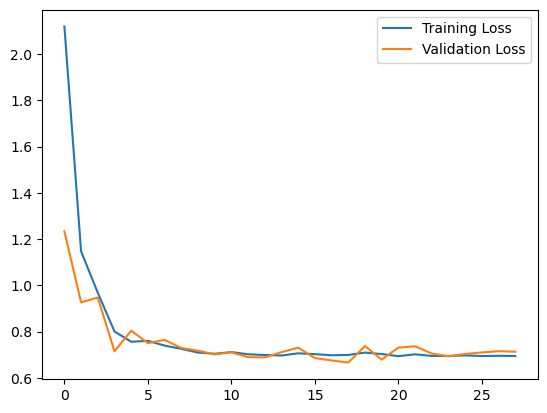

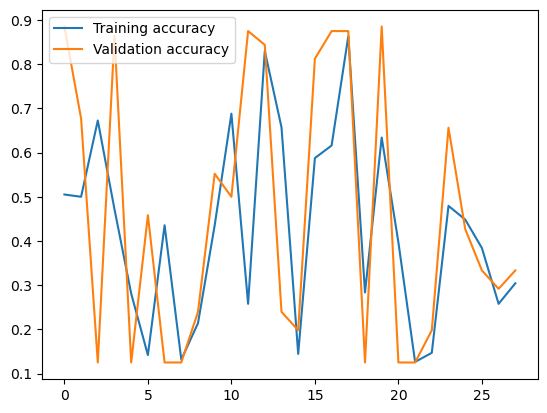

13/13 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       339 |         0 |
+-----------+---------

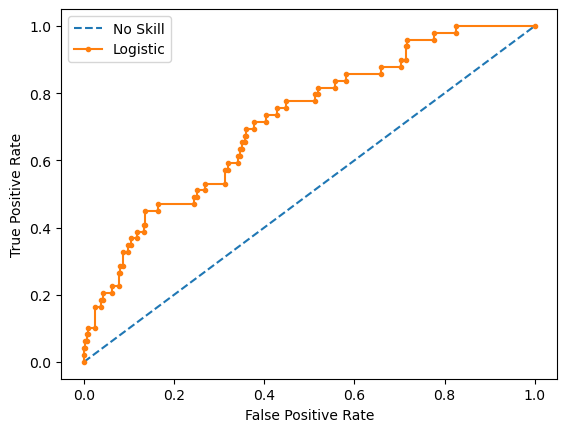

3/3 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        84 |         0 |
+-----------+-----------+
|        12 |         0 |
+-----------+-----------+
0.5
0.8343253968253969


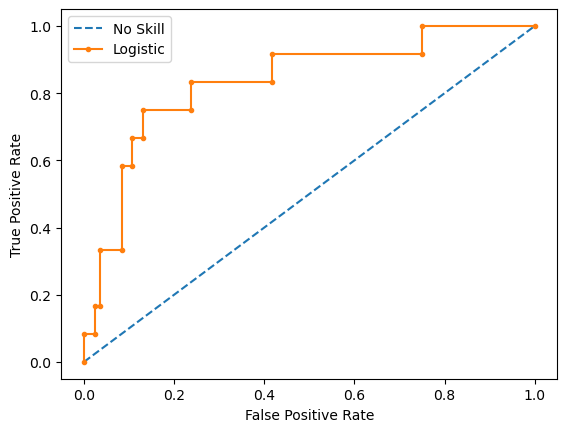

7/7 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.7189995796553174


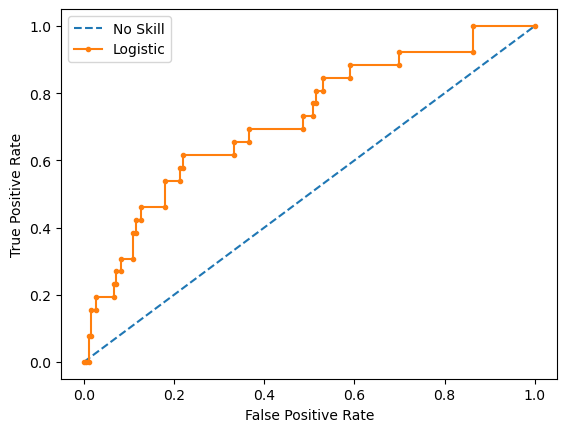

Fold Train F1 Score Validation F1 Score Test F1 Score Train AUC   Val AUC  \
0    1       0.266667                 0.2      0.205128  0.681802   0.57451   
1    2       0.411215            0.173913      0.377358  0.761744  0.637255   
2    3            0.0                 0.0           0.0  0.660609  0.485294   
3    4       0.103448            0.133333      0.176471   0.74662  0.480769   
4    5            0.0                 0.0           0.0  0.715911  0.834325   
5  3.0       0.156266            0.101449      0.151791  0.713337  0.602431   

   Test AUC  
0  0.715847  
1  0.771122  
2  0.571459  
3  0.684952  
4     0.719  
5  0.692476

In [527]:
skfold_loop()

In [523]:
# (10, 1)
# l1 0.1: all 1s or 0s
# l2 0.1: almost all 0s
# l1 0.01: all 1s or 0s
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: close to random guessing
# l1 0.0001: close to random guessing
# l2 0.0001: close to random guessing

# (25, 1)
# l1 0.1: all 1s or 0s
# l2 0.1: almost all 0s
# l1 0.01: all 1s or 0s
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: very mildly better, only just, not good enough
# l1 0.0001: close to random guessing
# l2 0.0001: close to random guessing

# (50, 1)
# l1 0.1: all 1s or 0s
# l2 0.1: almost all 0s
# l1 0.01: all 1s or 0s
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: somewhat better, not good enough
# l1 0.0001: close to random guessing
# l2 0.0001: close to random guessing

# (100, 1)
# l1 0.1: all 1s or 0s
# l2 0.1: almost all 0s
# l1 0.01: all 1s or 0s
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: somewhat better, not good enough
# l1 0.0001: worse than random guessing
# l2 0.0001: close to random guessing

## 3

In [620]:
def create_model():
    model = Sequential([
        Dense(50, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.01)), #activation = 'relu',
        LeakyReLU(alpha = 0.1),
        # BatchNormalization(),
        Dropout(0.2),
        Dense(50, kernel_regularizer=l2(0.01)), #activation = 'relu',
        LeakyReLU(alpha = 0.1),
        # BatchNormalization(),
        Dropout(0.2),
        # Dense(6),
        Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.01)) #, input_shape = [X_train_1.shape[1]]
    ])
    lr = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
    model.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}

Fold 1/5
Epoch 1/600
13/13 [==============================] - 3s 41ms/step - loss: 1.5468 - accuracy: 0.4961 - val_loss: 1.4865 - val_accuracy: 0.5670
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4895 - accuracy: 0.5452 - val_loss: 1.4398 - val_accuracy: 0.6289
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4307 - accuracy: 0.5814 - val_loss: 1.3952 - val_accuracy: 0.6392
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3808 - accuracy: 0.6331 - val_loss: 1.3474 - val_accuracy: 0.6701
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3215 - accuracy: 0.6744 - val_loss: 1.3067 - val_accuracy: 0.7216
Epoch 6/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3197 - accuracy: 0.6848 - val_loss: 1.2765 - val_accuracy: 0.7113
Epoch 7/600
13/13 [==============================] - 0s 10ms/step - loss: 1.2994 - accuracy: 0.7003 - val_loss: 1.2558 - val_accuracy: 0.72

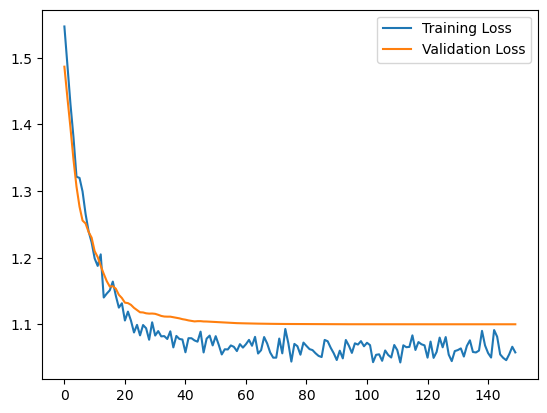

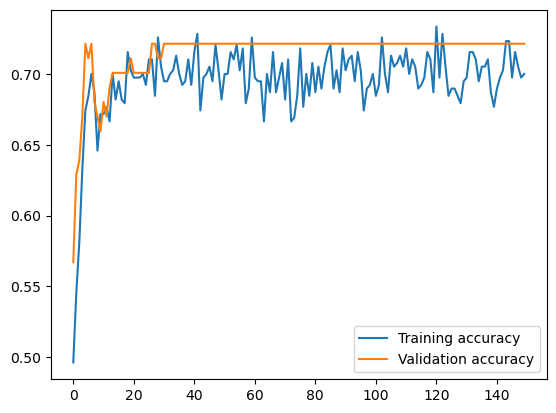

13/13 [==============================] - 0s 4ms/step
f1 score:  0.3769633507853403
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0
 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0
 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0
 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       232 |       106 |
+--------

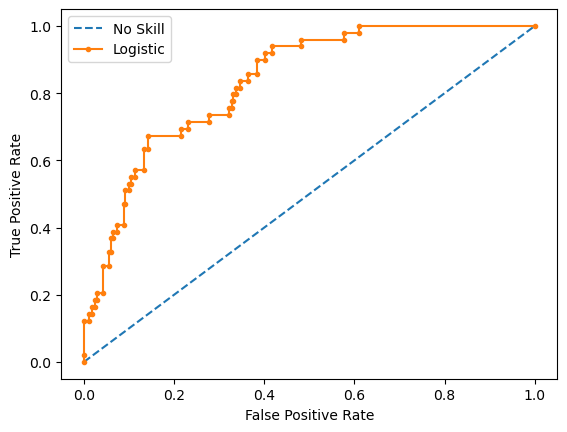

4/4 [==============================] - 0s 7ms/step
f1 score:  0.34146341463414637
[0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        63 |        22 |
+-----------+-----------+
|         5 |         7 |
+-----------+-----------+
0.5
0.6411764705882353


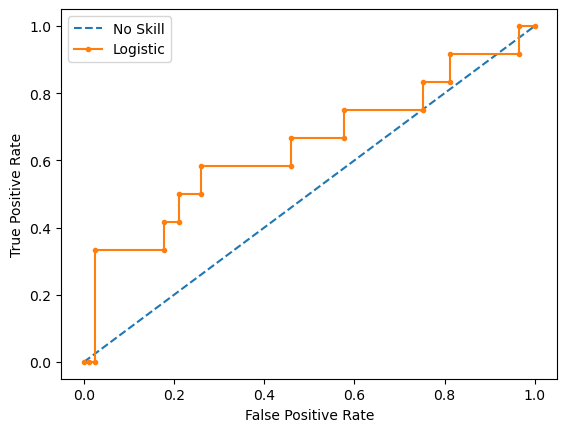

7/7 [==============================] - 0s 3ms/step
f1 score:  0.37362637362637363
[0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       135 |        48 |
+-----------+-----------+
|         9 |        17 |
+-----------+-----------+
0.5
0.7412778478352249


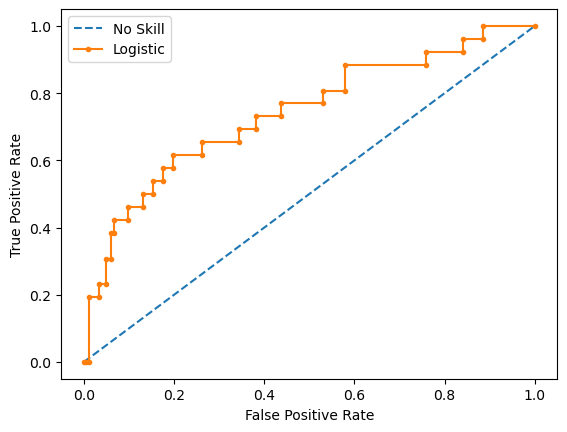

C:\Users\aniru\AppData\Local\Temp\ipykernel_12464\705718930.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],


Fold 2/5
Epoch 1/600
13/13 [==============================] - 4s 52ms/step - loss: 1.5418 - accuracy: 0.3876 - val_loss: 1.5478 - val_accuracy: 0.4124
Epoch 2/600
13/13 [==============================] - 0s 11ms/step - loss: 1.4671 - accuracy: 0.5116 - val_loss: 1.4319 - val_accuracy: 0.5464
Epoch 3/600
13/13 [==============================] - 0s 11ms/step - loss: 1.4048 - accuracy: 0.5917 - val_loss: 1.3942 - val_accuracy: 0.5567
Epoch 4/600
13/13 [==============================] - 0s 11ms/step - loss: 1.3790 - accuracy: 0.5814 - val_loss: 1.3464 - val_accuracy: 0.6186
Epoch 5/600
13/13 [==============================] - 0s 11ms/step - loss: 1.3091 - accuracy: 0.6589 - val_loss: 1.3010 - val_accuracy: 0.6598
Epoch 6/600
13/13 [==============================] - 0s 11ms/step - loss: 1.2857 - accuracy: 0.6537 - val_loss: 1.2732 - val_accuracy: 0.6701
Epoch 7/600
13/13 [==============================] - 0s 11ms/step - loss: 1.2574 - accuracy: 0.6718 - val_loss: 1.2516 - val_accuracy: 0.65

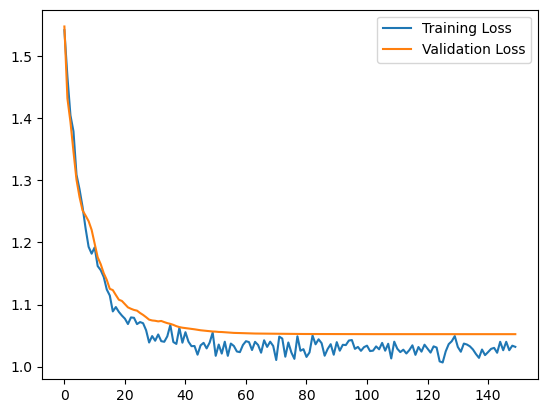

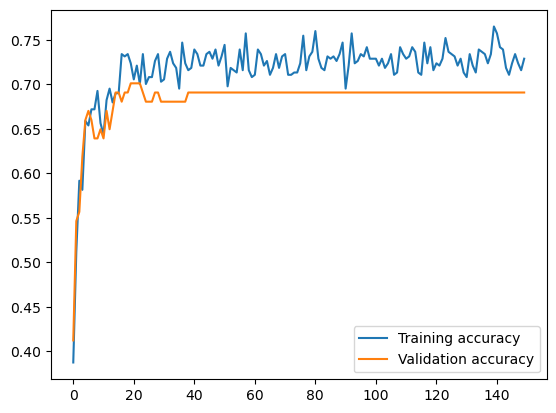

13/13 [==============================] - 0s 3ms/step
f1 score:  0.41916167664670656
[1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       255 |        83 |
+-------

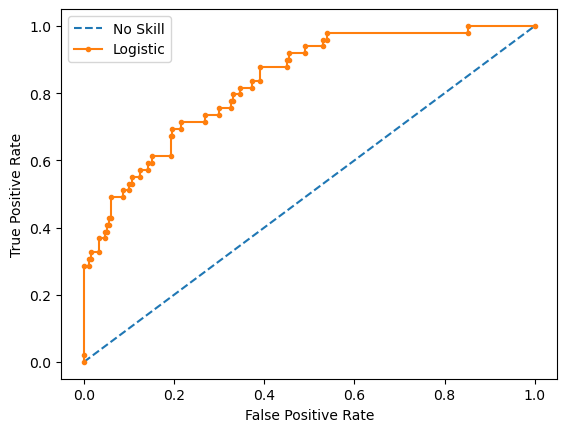

4/4 [==============================] - 0s 4ms/step
f1 score:  0.25
[0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        62 |        23 |
+-----------+-----------+
|         7 |         5 |
+-----------+-----------+
0.5
0.6499999999999999


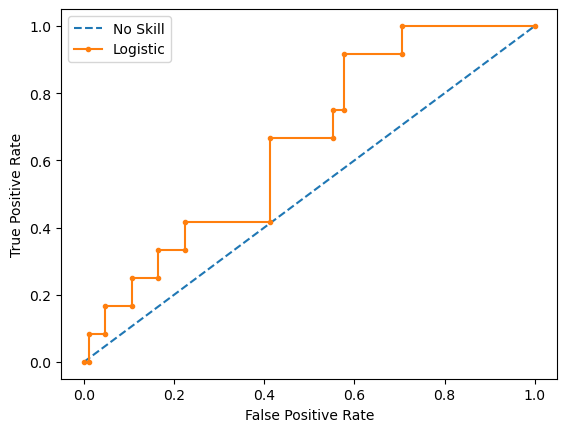

7/7 [==============================] - 0s 4ms/step
f1 score:  0.41860465116279066
[0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1
 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       141 |        42 |
+-----------+-----------+
|         8 |        18 |
+-----------+-----------+
0.5
0.7744850777637663


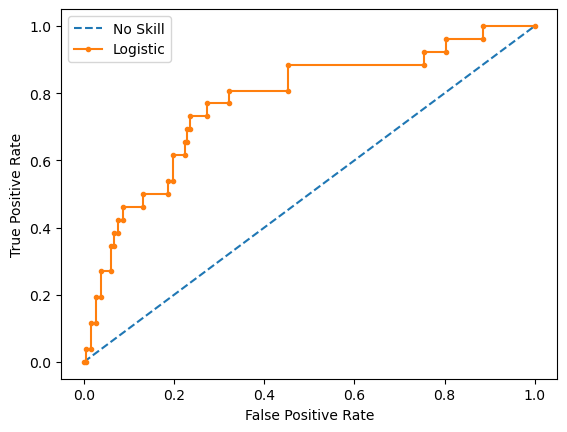

Fold 3/5
Epoch 1/600
13/13 [==============================] - 3s 43ms/step - loss: 1.5724 - accuracy: 0.5452 - val_loss: 1.4673 - val_accuracy: 0.6495
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4874 - accuracy: 0.6331 - val_loss: 1.3978 - val_accuracy: 0.6392
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4530 - accuracy: 0.6512 - val_loss: 1.3641 - val_accuracy: 0.6701
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3847 - accuracy: 0.6434 - val_loss: 1.3312 - val_accuracy: 0.6598
Epoch 5/600
13/13 [==============================] - 0s 11ms/step - loss: 1.3443 - accuracy: 0.6615 - val_loss: 1.3122 - val_accuracy: 0.6804
Epoch 6/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3156 - accuracy: 0.6744 - val_loss: 1.2717 - val_accuracy: 0.7010
Epoch 7/600
13/13 [==============================] - 0s 10ms/step - loss: 1.2922 - accuracy: 0.7158 - val_loss: 1.2414 - val_accuracy: 0.70

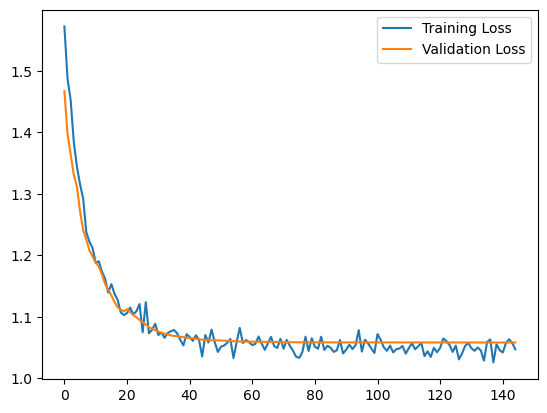

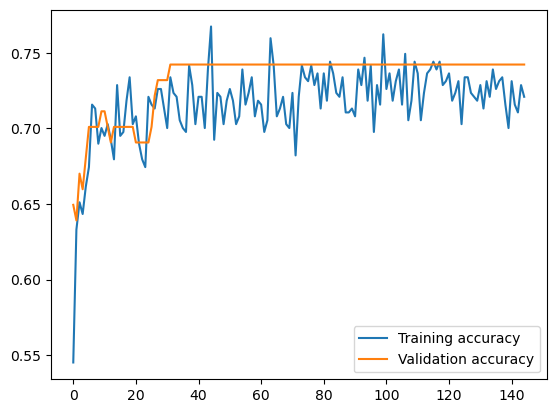

13/13 [==============================] - 0s 3ms/step
f1 score:  0.4519774011299435
[0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1
 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       250 |        88 |
+--------

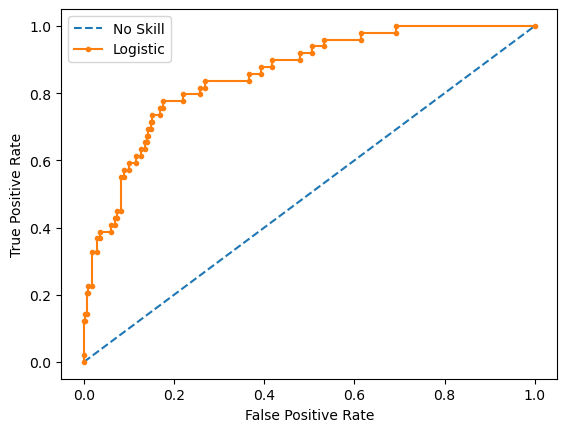

4/4 [==============================] - 0s 4ms/step
f1 score:  0.32432432432432434
[1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        66 |        19 |
+-----------+-----------+
|         6 |         6 |
+-----------+-----------+
0.5
0.6901960784313725


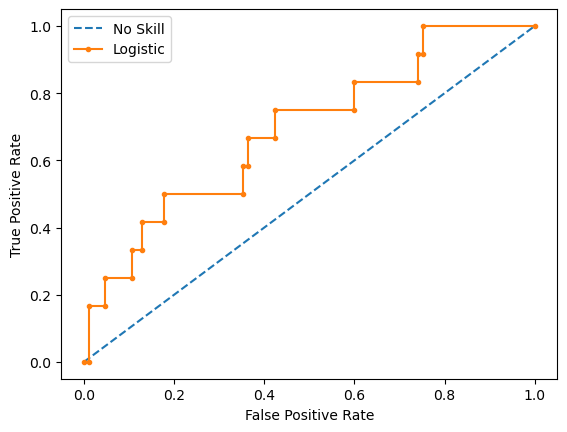

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3595505617977528
[1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1
 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       136 |        47 |
+-----------+-----------+
|        10 |        16 |
+-----------+-----------+
0.5
0.7494745691467003


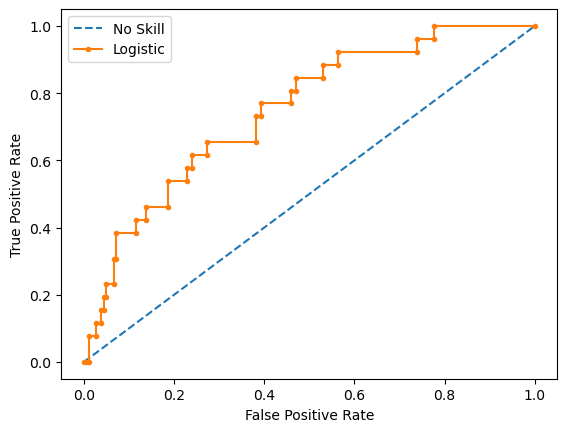

Fold 4/5
Epoch 1/600
13/13 [==============================] - 3s 43ms/step - loss: 1.6047 - accuracy: 0.7700 - val_loss: 1.3955 - val_accuracy: 0.7526
Epoch 2/600
13/13 [==============================] - 0s 11ms/step - loss: 1.5201 - accuracy: 0.7183 - val_loss: 1.4121 - val_accuracy: 0.6804
Epoch 3/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4294 - accuracy: 0.7209 - val_loss: 1.3939 - val_accuracy: 0.6495
Epoch 4/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3969 - accuracy: 0.6925 - val_loss: 1.3804 - val_accuracy: 0.5979
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3414 - accuracy: 0.6822 - val_loss: 1.3538 - val_accuracy: 0.6186
Epoch 6/600
13/13 [==============================] - 0s 9ms/step - loss: 1.3149 - accuracy: 0.7003 - val_loss: 1.3240 - val_accuracy: 0.6186
Epoch 7/600
13/13 [==============================] - 0s 10ms/step - loss: 1.2892 - accuracy: 0.7183 - val_loss: 1.3182 - val_accuracy: 0.628

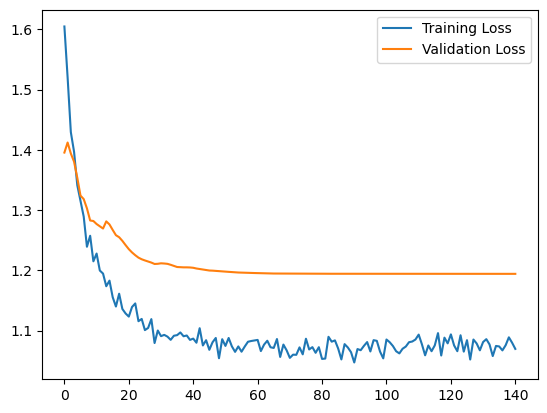

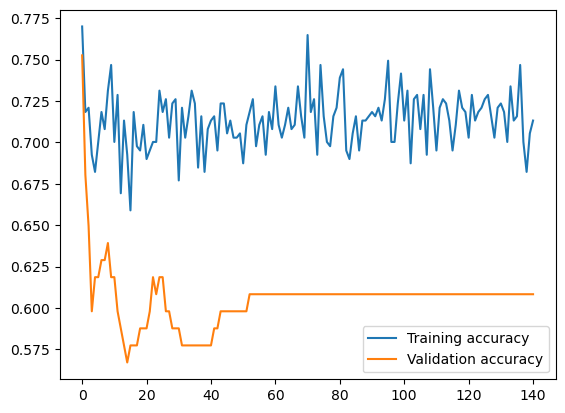

13/13 [==============================] - 0s 4ms/step
f1 score:  0.4269662921348315
[0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0
 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       247 |        92 |
+--------

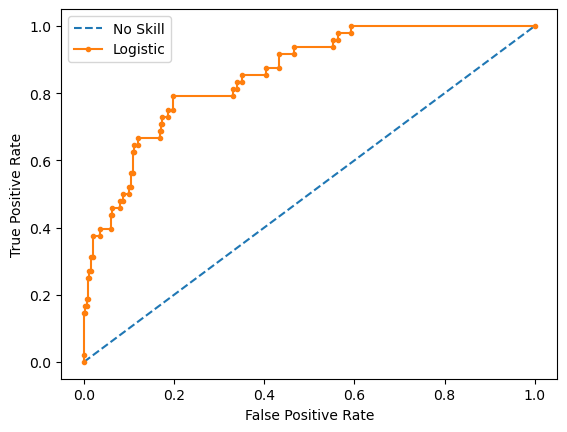

4/4 [==============================] - 0s 3ms/step
f1 score:  0.20833333333333331
[0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1
 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        54 |        30 |
+-----------+-----------+
|         8 |         5 |
+-----------+-----------+
0.5
0.532051282051282


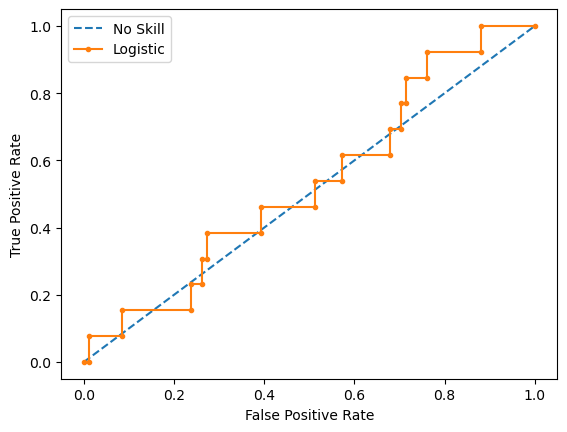

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3404255319148936
[0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       131 |        52 |
+-----------+-----------+
|        10 |        16 |
+-----------+-----------+
0.5
0.6935687263556117


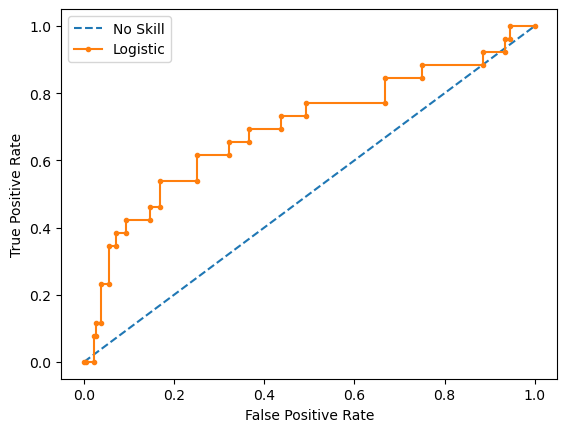

Fold 5/5
Epoch 1/600
13/13 [==============================] - 3s 41ms/step - loss: 1.5886 - accuracy: 0.5799 - val_loss: 1.4386 - val_accuracy: 0.6562
Epoch 2/600
13/13 [==============================] - 0s 10ms/step - loss: 1.4857 - accuracy: 0.6186 - val_loss: 1.3888 - val_accuracy: 0.6562
Epoch 3/600
13/13 [==============================] - 0s 9ms/step - loss: 1.4213 - accuracy: 0.6418 - val_loss: 1.3354 - val_accuracy: 0.7500
Epoch 4/600
13/13 [==============================] - 0s 9ms/step - loss: 1.3965 - accuracy: 0.6675 - val_loss: 1.3065 - val_accuracy: 0.7604
Epoch 5/600
13/13 [==============================] - 0s 10ms/step - loss: 1.3514 - accuracy: 0.6881 - val_loss: 1.3015 - val_accuracy: 0.6771
Epoch 6/600
13/13 [==============================] - 0s 9ms/step - loss: 1.3139 - accuracy: 0.6392 - val_loss: 1.2842 - val_accuracy: 0.6979
Epoch 7/600
13/13 [==============================] - 0s 9ms/step - loss: 1.2921 - accuracy: 0.6495 - val_loss: 1.2560 - val_accuracy: 0.7083
E

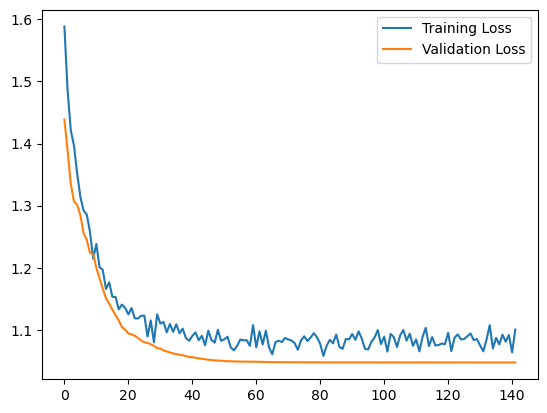

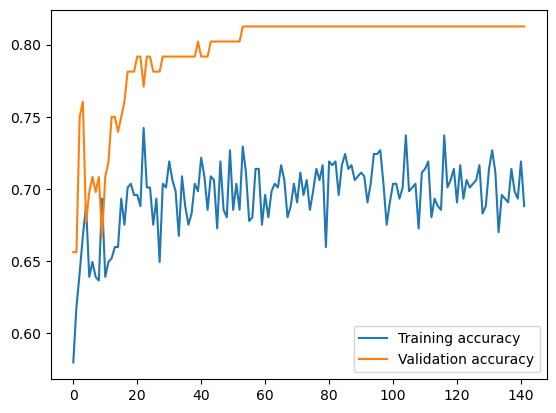

13/13 [==============================] - 0s 3ms/step
f1 score:  0.3958333333333333
[0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0
 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1
 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       234 |       105 |
+------

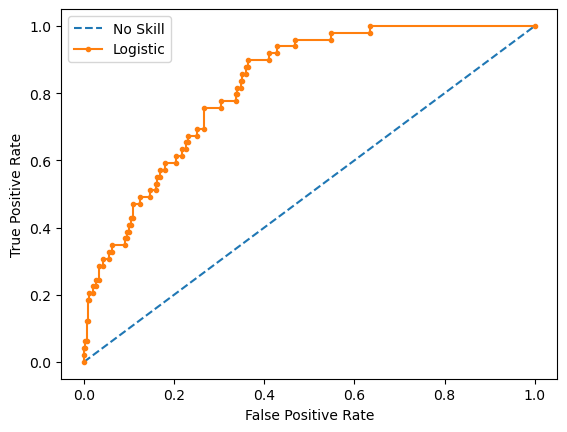

3/3 [==============================] - 0s 6ms/step
f1 score:  0.4705882352941177
[0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        70 |        14 |
+-----------+-----------+
|         4 |         8 |
+-----------+-----------+
0.5
0.7867063492063492


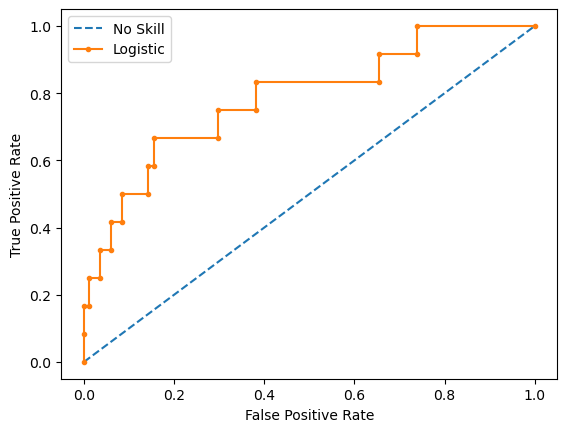

7/7 [==============================] - 0s 3ms/step
f1 score:  0.3404255319148936
[0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1
 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       131 |        52 |
+-----------+-----------+
|        10 |        16 |
+-----------+-----------+
0.5
0.7032366540563262


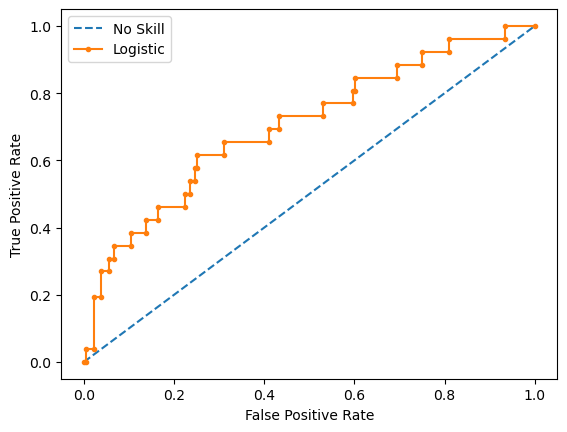

Fold Train F1 Score Validation F1 Score Test F1 Score Train AUC   Val AUC  \
0    1       0.376963            0.341463      0.373626  0.835104  0.641176   
1    2       0.419162                0.25      0.418605  0.833414      0.65   
2    3       0.451977            0.324324      0.359551  0.855754  0.690196   
3    4       0.426966            0.208333      0.340426  0.855273  0.532051   
4    5       0.395833            0.470588      0.340426  0.822527  0.786706   
5  3.0        0.41418            0.318942      0.366527  0.840415  0.660026   

   Test AUC  
0  0.741278  
1  0.774485  
2  0.749475  
3  0.693569  
4  0.703237  
5  0.732409

In [621]:
skfold_loop()

In [586]:
# (10, 10, 1)
# l1 0.1: close to random guessing
# l2 0.1: marginally better, not good enough (in fact, close to random guessing)
# l1 0.01: worse than random guessing
# l2 0.01: marginally better, not good enough (in fact, close to random guessing)
# l1 0.001: close to random guessing
# l2 0.001: marginally better, not good enough (in fact, close to random guessing)
# l1 0.0001: close to random guessing
# l2 0.0001: marginally better, not good enough

# (20, 10, 1)
# l1 0.1: close to random guessing
# l2 0.1: just better, not good enough
# l1 0.01: close to random guessing
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: just better, not good enough
# l1 0.0001: just better, not good enough
# l2 0.0001: just better, not good enough

# (20, 20, 1)
# l1 0.1: close to random guessing
# l2 0.1: just better, not good enough
# l1 0.01: close to random guessing
# l2 0.01: just better, not good enough
# l1 0.001: close to random guessing
# l2 0.001: just better, not good enough
# l1 0.0001: close to random guessing
# l2 0.0001: just better, not good enough

# (256, 256, 1)
# l1 0.1: close to random guessing
# l2 0.1: just better, not good enough
# l1 0.01: close to random guessing
# l2 0.01: close to random guessing
# l1 0.001: close to random guessing
# l2 0.001: close to random guessing
# l1 0.0001: close to random guessing
# l2 0.0001: just better, not good enough

# Undersampling

## Prep

In [625]:
X_nontest = X_nt.copy()
y_nontest = y_nt.copy()
X_test = X_t.copy()
y_test = y_t.copy()

In [626]:
undersampler = RandomUnderSampler(random_state=42)
X_nt_resampled, y_nt_resampled = undersampler.fit_resample(X_nontest, y_nontest)

In [627]:
X_train_und, X_val_und, y_train_und, y_val_und = train_test_split(X_nt_resampled, y_nt_resampled, test_size = 0.3, stratify = y_nt_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_nontest, y_nontest, test_size = 0.3, stratify = y_nontest)

In [628]:
X_train_und_pp, X_test_und_pp, X_val_und_pp = preprocessor(X_train_und, X_test, X_val_und)

## 1

In [632]:
model_basic = Sequential([
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_basic.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [633]:
history = model.fit(X_train_und_pp, y_train_und, epochs = 600, batch_size = len(X_train_und_pp), validation_data = [X_val_und_pp, y_val_und],
                                callbacks = [early_stopping])

Epoch 1/600
1/1 [==============================] - 0s 198ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 2/600
1/1 [==============================] - 0s 71ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 3/600
1/1 [==============================] - 0s 93ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 4/600
1/1 [==============================] - 0s 75ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 5/600
1/1 [==============================] - 0s 68ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 6/600
1/1 [==============================] - 0s 75ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 7/600
1/1 [==============================] - 0s 74ms/step - loss: 0.9367 - accuracy: 0.5765 - val_loss: 0.9135 - val_accuracy: 0.5405
Epoch 8/600
1/1 [==

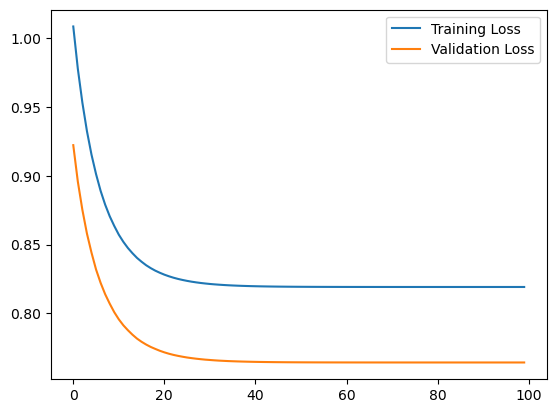

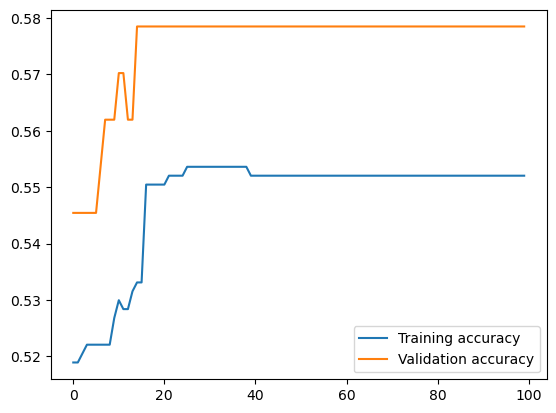

3/3 [==============================] - 0s 4ms/step
f1 score:  0.45977011494252873
[0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0 1 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        18 |        25 |
+-----------+-----------+
|        22 |        20 |
+-----------+-----------+
0.5
0.49612403100775193


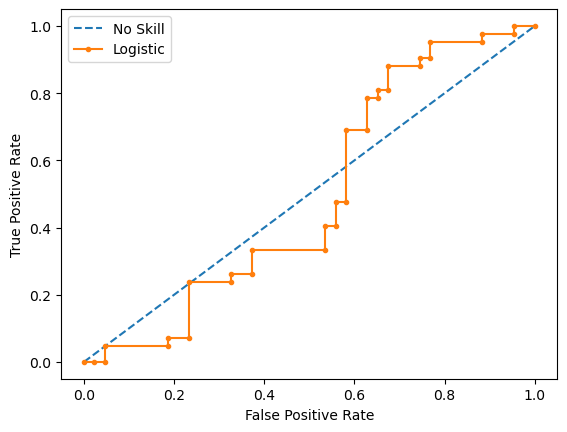

2/2 [==============================] - 0s 5ms/step
f1 score:  0.6666666666666666
[0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|         9 |         9 |
+-----------+-----------+
|         5 |        14 |
+-----------+-----------+
0.5
0.6578947368421053


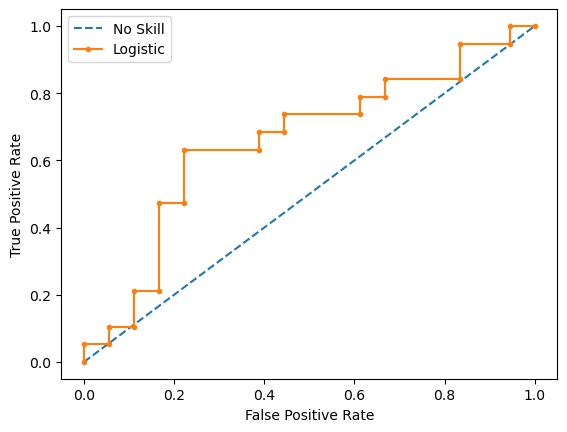

7/7 [==============================] - 0s 3ms/step
f1 score:  0.1842105263157895
[0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1
 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1
 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1
 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0
 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1
 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        71 |       112 |
+-----------+-----------+
|        12 |        14 |
+-----------+-----------+
0.5
0.4579655317360236


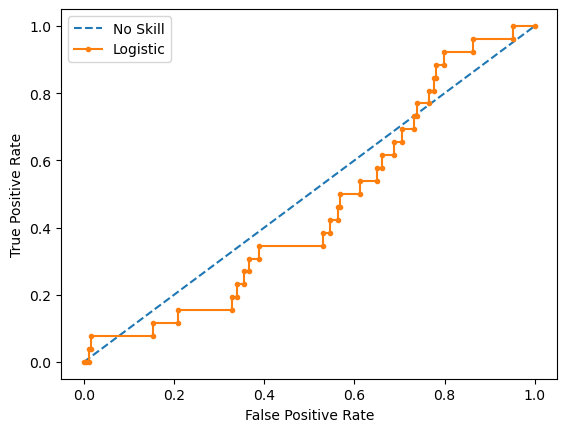

In [634]:
history_plotter(history_basic)
results(model_basic, X_train_und_pp, y_train_und)
results(model_basic, X_val_und_pp, y_val_und)
results(model_basic, X_test_und_pp, y_test)
winsound.Beep(1000, 1000)

## 2

In [650]:
model_2 = Sequential([
    Dense(50, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.01)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
    # LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.01)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_2.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [651]:
history_2 = model_2.fit(X_train_und_pp, y_train_und, epochs = 600, batch_size = 32, validation_data = [X_val_und_pp, y_val_und],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
3/3 [==============================] - 3s 280ms/step - loss: 1.1237 - accuracy: 0.5059 - val_loss: 0.9741 - val_accuracy: 0.5405
Epoch 2/600
3/3 [==============================] - 0s 44ms/step - loss: 0.8898 - accuracy: 0.6941 - val_loss: 0.9552 - val_accuracy: 0.6216
Epoch 3/600
3/3 [==============================] - 0s 47ms/step - loss: 0.8351 - accuracy: 0.6941 - val_loss: 0.9555 - val_accuracy: 0.6216
Epoch 4/600
3/3 [==============================] - 0s 37ms/step - loss: 0.7899 - accuracy: 0.7059 - val_loss: 0.9547 - val_accuracy: 0.5676
Epoch 5/600
3/3 [==============================] - 0s 39ms/step - loss: 0.6992 - accuracy: 0.7647 - val_loss: 0.9508 - val_accuracy: 0.5676
Epoch 6/600
3/3 [==============================] - 0s 37ms/step - loss: 0.6675 - accuracy: 0.7765 - val_loss: 0.9451 - val_accuracy: 0.5405
Epoch 7/600
3/3 [==============================] - 0s 56ms/step - loss: 0.6306 - accuracy: 0.7765 - val_loss: 0.9413 - val_accuracy: 0.5135
Epoch 8/600
3/3 [==

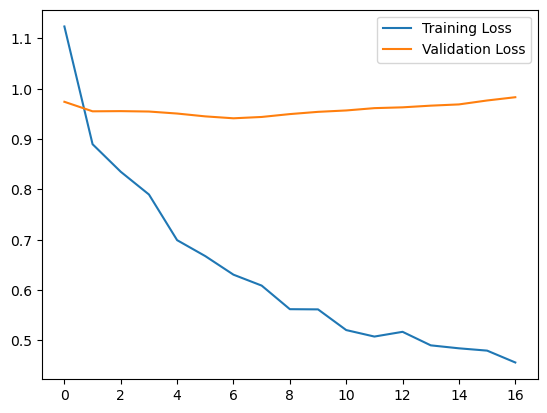

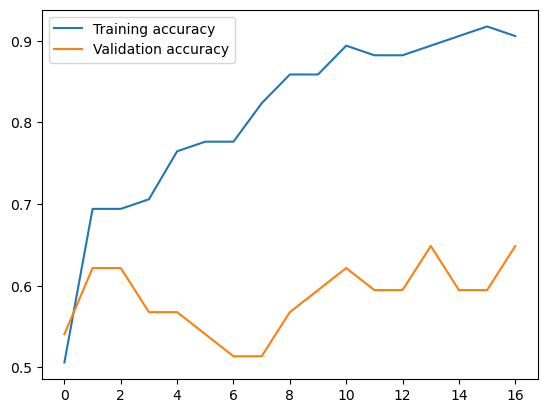

3/3 [==============================] - 0s 5ms/step
f1 score:  0.8139534883720929
[0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0
 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0
 1 0 1 0 1 0 0 1 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        34 |         9 |
+-----------+-----------+
|         7 |        35 |
+-----------+-----------+
0.5
0.9280177187153931


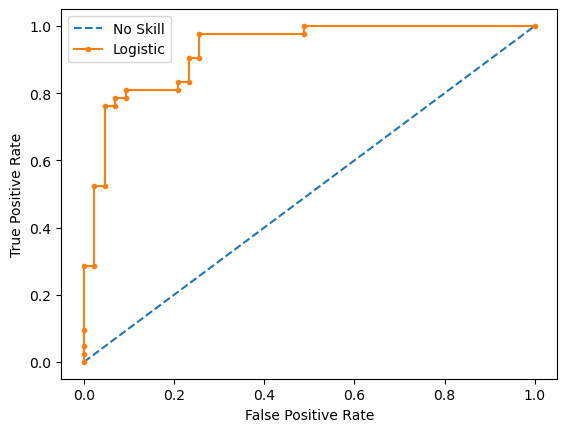

2/2 [==============================] - 0s 5ms/step
f1 score:  0.5500000000000002
[0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|         8 |        10 |
+-----------+-----------+
|         8 |        11 |
+-----------+-----------+
0.5
0.6169590643274853


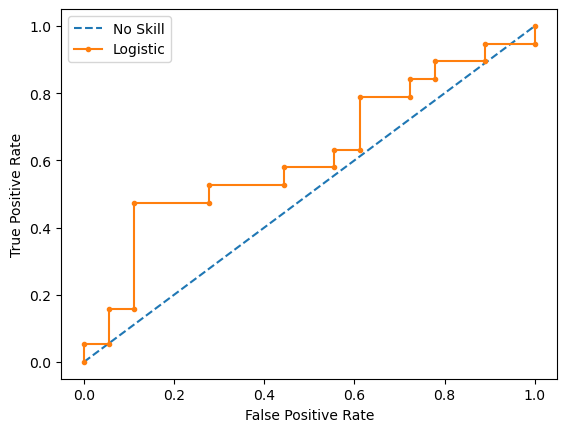

7/7 [==============================] - 0s 3ms/step
f1 score:  0.26785714285714285
[0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1
 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1
 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       112 |        71 |
+-----------+-----------+
|        11 |        15 |
+-----------+-----------+
0.5
0.5813366960907944


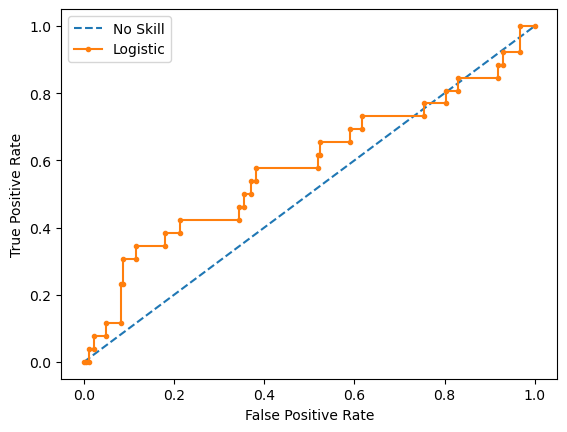

In [652]:
history_plotter(history_2)
results(model_2, X_train_und_pp, y_train_und)
results(model_2, X_val_und_pp, y_val_und)
results(model_2, X_test_und_pp, y_test)
winsound.Beep(1000, 1000)

## 3

In [728]:
model_3 = Sequential([
    Dense(50, input_shape = [X_train_1.shape[1]], kernel_regularizer=l1(0.01)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(50, kernel_regularizer=l1(0.1)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l1(0.01)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_3.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [685]:
history_3 = model_3.fit(X_train_und_pp, y_train_und, epochs = 600, batch_size = 32, validation_data = [X_val_und_pp, y_val_und],
                                callbacks = [early_stopping]) #, class_weight = {0:1, 1:6.89})

Epoch 1/600
3/3 [==============================] - 3s 256ms/step - loss: 33.2444 - accuracy: 0.5412 - val_loss: 32.6886 - val_accuracy: 0.5135
Epoch 2/600
3/3 [==============================] - 0s 34ms/step - loss: 32.4569 - accuracy: 0.5294 - val_loss: 31.9262 - val_accuracy: 0.4865
Epoch 3/600
3/3 [==============================] - 0s 37ms/step - loss: 31.7355 - accuracy: 0.5412 - val_loss: 31.1724 - val_accuracy: 0.4595
Epoch 4/600
3/3 [==============================] - 0s 34ms/step - loss: 30.9704 - accuracy: 0.4941 - val_loss: 30.4264 - val_accuracy: 0.4865
Epoch 5/600
3/3 [==============================] - 0s 35ms/step - loss: 30.2053 - accuracy: 0.4941 - val_loss: 29.6925 - val_accuracy: 0.4865
Epoch 6/600
3/3 [==============================] - 0s 36ms/step - loss: 29.5196 - accuracy: 0.4941 - val_loss: 29.0442 - val_accuracy: 0.4865
Epoch 7/600
3/3 [==============================] - 0s 34ms/step - loss: 28.8239 - accuracy: 0.6235 - val_loss: 28.4047 - val_accuracy: 0.4865
Epoch

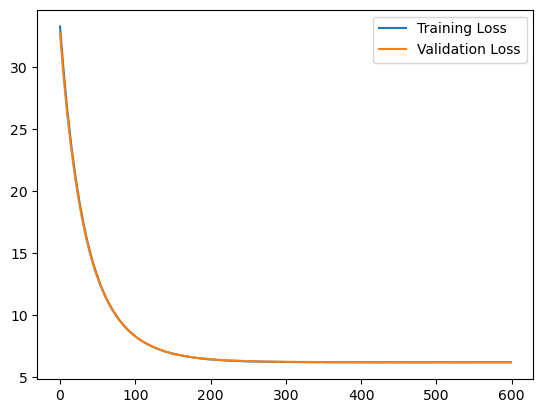

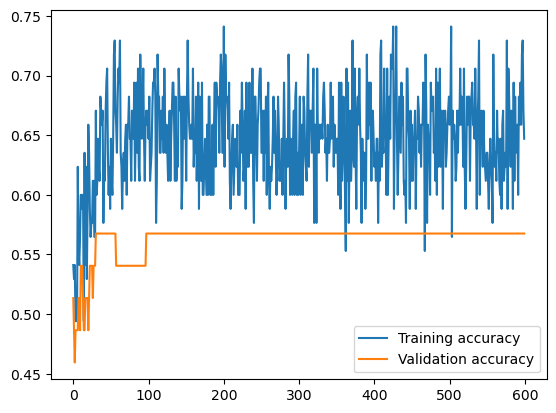

3/3 [==============================] - 0s 6ms/step
f1 score:  0.5312499999999999
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        38 |         5 |
+-----------+-----------+
|        25 |        17 |
+-----------+-----------+
0.5
0.8277962347729789


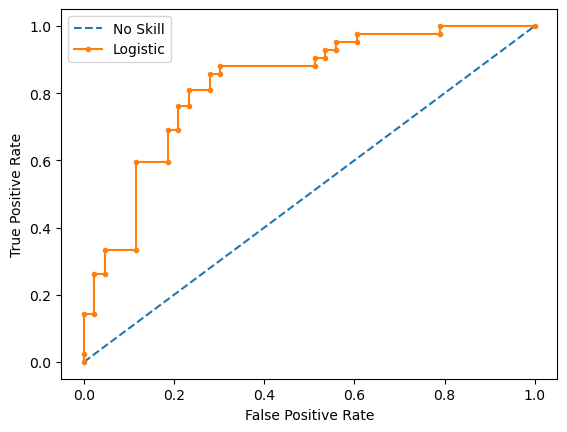

2/2 [==============================] - 0s 0s/step
f1 score:  0.4666666666666667
[0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        14 |         4 |
+-----------+-----------+
|        12 |         7 |
+-----------+-----------+
0.5
0.608187134502924


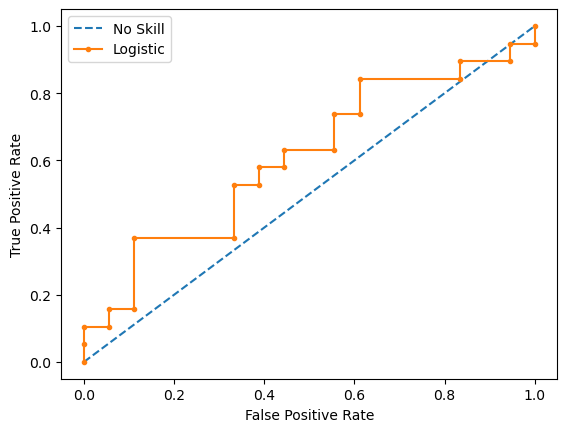

7/7 [==============================] - 0s 3ms/step
f1 score:  0.1772151898734177
[0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       137 |        46 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+
0.5
0.5617906683480454


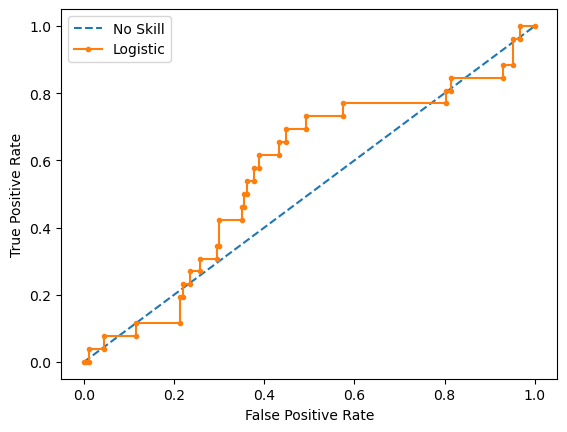

In [686]:
history_plotter(history_3)
results(model_3, X_train_und_pp, y_train_und)
results(model_3, X_val_und_pp, y_val_und)
results(model_3, X_test_und_pp, y_test)
winsound.Beep(1000, 1000)

# Focal Loss

## Prep

In [689]:
X_train_pp, X_test_pp, X_val_pp = preprocessor(X_train, X_test, X_val)

In [690]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal Loss implementation."""
    epsilon = 1e-8
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # Clip predicted probabilities to prevent NaNs
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))  # Actual probability for the positive class
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))  # Actual probability for the negative class
    loss = -alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1) - (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0)
    return tf.reduce_mean(loss)

In [714]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

## 1

In [721]:
model_basic = Sequential([
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.1)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_basic.compile(optimizer = Adam(learning_rate = lr_schedule), loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=False),
                    metrics = ['accuracy'])

In [722]:
history_basic = model_basic.fit(X_train_pp, y_train, epochs = 600, batch_size = 17, validation_data = [X_val_pp, y_val],
                                callbacks = [early_stopping])

Epoch 1/600
20/20 [==============================] - 2s 28ms/step - loss: 0.1769 - accuracy: 0.8047 - val_loss: 0.1120 - val_accuracy: 0.8767
Epoch 2/600
20/20 [==============================] - 0s 9ms/step - loss: 0.1351 - accuracy: 0.8639 - val_loss: 0.1120 - val_accuracy: 0.8630
Epoch 3/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.8698 - val_loss: 0.0974 - val_accuracy: 0.8767
Epoch 4/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1092 - accuracy: 0.8639 - val_loss: 0.1157 - val_accuracy: 0.8493
Epoch 5/600
20/20 [==============================] - 0s 9ms/step - loss: 0.1186 - accuracy: 0.8609 - val_loss: 0.0974 - val_accuracy: 0.8699
Epoch 6/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1126 - accuracy: 0.8669 - val_loss: 0.0979 - val_accuracy: 0.8767
Epoch 7/600
20/20 [==============================] - 0s 8ms/step - loss: 0.1056 - accuracy: 0.8698 - val_loss: 0.1030 - val_accuracy: 0.8699
Epoch 8/600


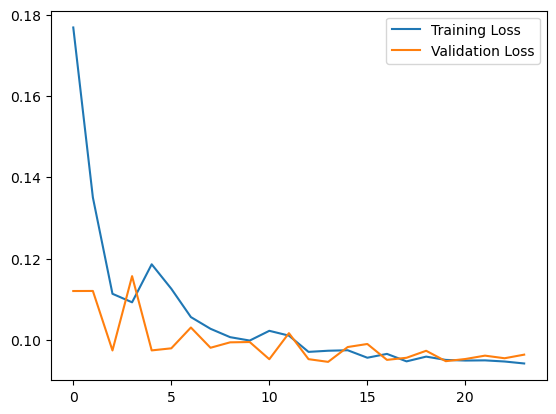

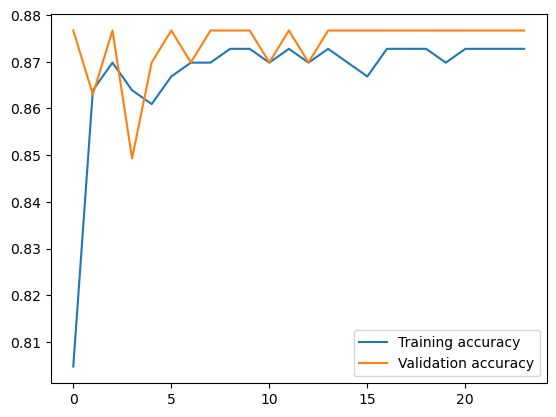

11/11 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       295 |         0 |
+-----------+-----------+
|        43 |         0 |
+-----------+-----------+
0.5
0.7746156878202601


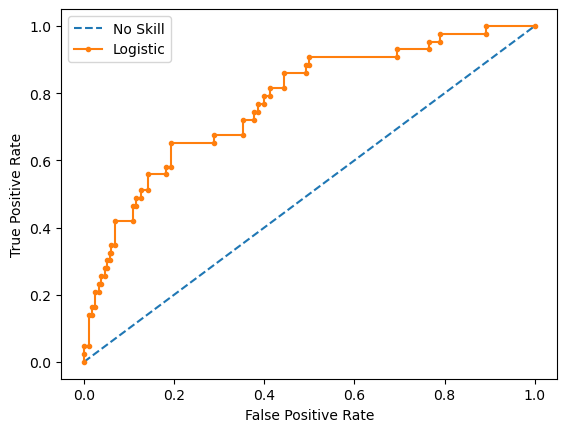

5/5 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       128 |         0 |
+-----------+-----------+
|        18 |         0 |
+-----------+-----------+
0.5
0.7595486111111112


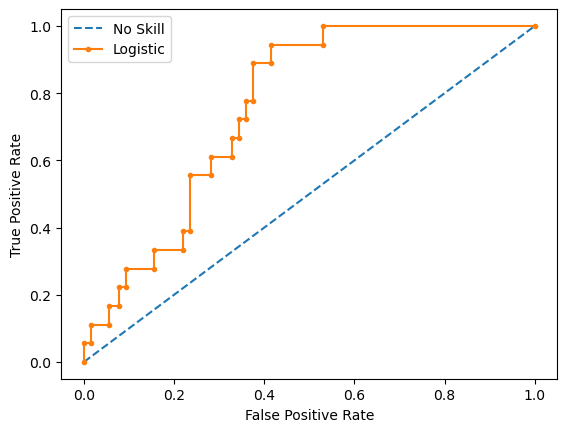

7/7 [==============================] - 0s 4ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.667927700714586


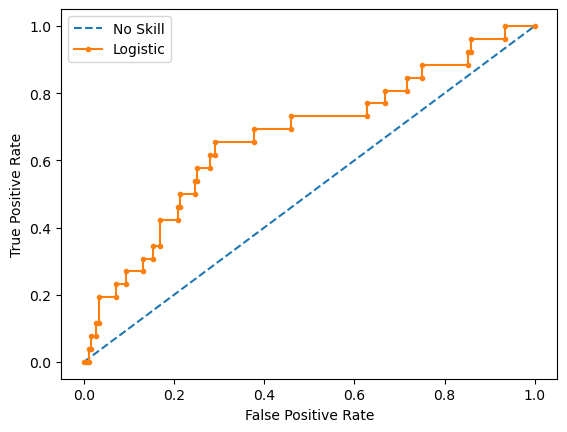

In [723]:
history_plotter(history_basic)
auc_train, f1_train = results(model_basic, X_train_pp, y_train)
auc_val, f1_val = results(model_basic, X_val_pp, y_val)
auc_test, f1_test = results(model_basic, X_test_pp, y_test)
winsound.Beep(1000, 1000)

## 2

In [724]:
model_2 = Sequential([
    Dense(50, input_shape = [X_train_1.shape[1]], kernel_regularizer=l2(0.01)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(10, kernel_regularizer=l1(0.1)), #activation = 'relu',
    # LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.01)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_2.compile(optimizer = Adam(learning_rate = lr_schedule), loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=False), metrics = ['accuracy'])

In [725]:
history_2 = model_2.fit(X_train_pp, y_train, epochs = 600, batch_size = 17, validation_data = [X_val_pp, y_val],
                                callbacks = [early_stopping])

Epoch 1/600
20/20 [==============================] - 3s 38ms/step - loss: 0.6055 - accuracy: 0.4615 - val_loss: 0.5911 - val_accuracy: 0.4658
Epoch 2/600
20/20 [==============================] - 0s 9ms/step - loss: 0.5990 - accuracy: 0.4941 - val_loss: 0.5774 - val_accuracy: 0.4726
Epoch 3/600
20/20 [==============================] - 0s 9ms/step - loss: 0.5673 - accuracy: 0.4763 - val_loss: 0.5659 - val_accuracy: 0.4863
Epoch 4/600
20/20 [==============================] - 0s 8ms/step - loss: 0.5629 - accuracy: 0.4793 - val_loss: 0.5569 - val_accuracy: 0.4932
Epoch 5/600
20/20 [==============================] - 0s 8ms/step - loss: 0.5649 - accuracy: 0.5118 - val_loss: 0.5494 - val_accuracy: 0.5068
Epoch 6/600
20/20 [==============================] - 0s 8ms/step - loss: 0.5524 - accuracy: 0.5237 - val_loss: 0.5432 - val_accuracy: 0.5274
Epoch 7/600
20/20 [==============================] - 0s 9ms/step - loss: 0.5380 - accuracy: 0.5414 - val_loss: 0.5381 - val_accuracy: 0.5274
Epoch 8/600


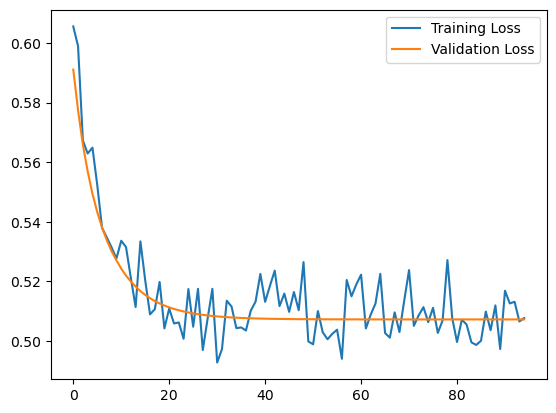

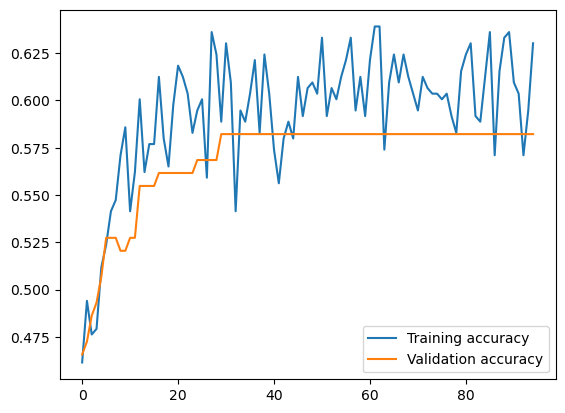

11/11 [==============================] - 0s 3ms/step
f1 score:  0.18518518518518517
[1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1
 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       191 |       104 |
+-----------+-----------+
|        28 |        15 |
+-----------+-----------+
0.5
0.5264485612928657


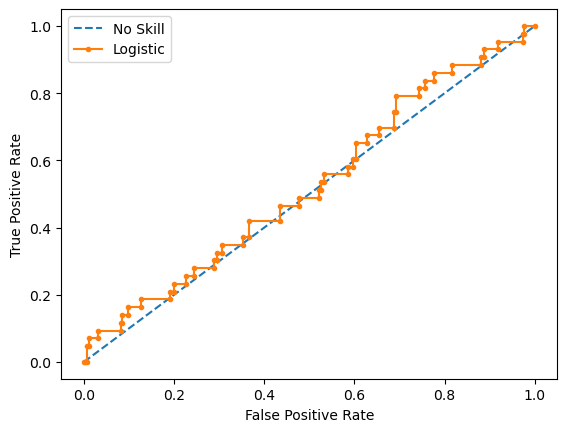

5/5 [==============================] - 0s 4ms/step
f1 score:  0.11594202898550723
[0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1
 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        81 |        47 |
+-----------+-----------+
|        14 |         4 |
+-----------+-----------+
0.5
0.41710069444444436


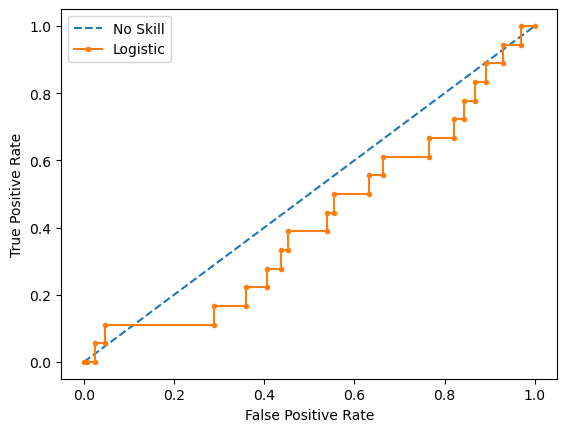

7/7 [==============================] - 0s 2ms/step
f1 score:  0.13861386138613863
[1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       115 |        68 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+
0.5
0.3703236654056326


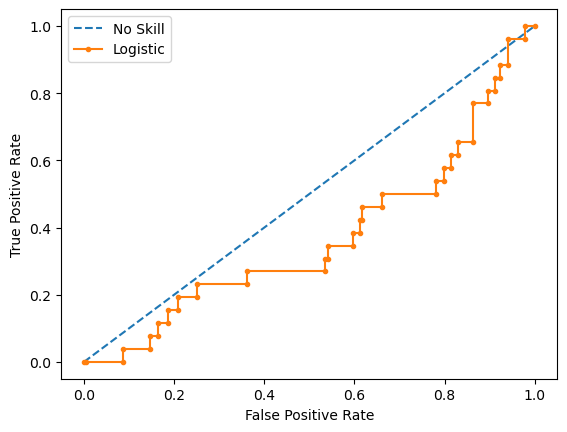

In [730]:
history_plotter(history_2)
auc_train, f1_train = results(model_2, X_train_pp, y_train)
auc_val, f1_val = results(model_2, X_val_pp, y_val)
auc_test, f1_test = results(model_2, X_test_pp, y_test)
winsound.Beep(1000, 1000)

## 3

In [792]:
model_3 = Sequential([
    Dense(50, input_shape = [X_train_1.shape[1]], kernel_regularizer=l1(0.001)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(50, kernel_regularizer=l1(0.001)), #activation = 'relu',
    LeakyReLU(alpha = 0.1),
    # BatchNormalization(),
    Dropout(0.2),
    # Dense(6),
    Dense(1, activation = 'sigmoid', kernel_regularizer=l1(0.001)) #, input_shape = [X_train_1.shape[1]]
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=15, decay_rate=0.9, staircase=True)
model_3.compile(optimizer = Adam(learning_rate = lr_schedule), loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=False), metrics = ['accuracy'])

In [793]:
history_3 = model_3.fit(X_train_pp, y_train, epochs = 600, batch_size = 17, validation_data = [X_val_pp, y_val],
                                callbacks = [early_stopping])

Epoch 1/600
20/20 [==============================] - 2s 20ms/step - loss: 1.1795 - accuracy: 0.7130 - val_loss: 1.1898 - val_accuracy: 0.8767
Epoch 2/600
20/20 [==============================] - 0s 6ms/step - loss: 1.1536 - accuracy: 0.8047 - val_loss: 1.0948 - val_accuracy: 0.6781
Epoch 3/600
20/20 [==============================] - 0s 5ms/step - loss: 0.9049 - accuracy: 0.8225 - val_loss: 0.7063 - val_accuracy: 0.8767
Epoch 4/600
20/20 [==============================] - 0s 5ms/step - loss: 0.6344 - accuracy: 0.8669 - val_loss: 0.5156 - val_accuracy: 0.8767
Epoch 5/600
20/20 [==============================] - 0s 5ms/step - loss: 0.4340 - accuracy: 0.8698 - val_loss: 0.3535 - val_accuracy: 0.8767
Epoch 6/600
20/20 [==============================] - 0s 6ms/step - loss: 0.3064 - accuracy: 0.8728 - val_loss: 0.2612 - val_accuracy: 0.8767
Epoch 7/600
20/20 [==============================] - 0s 5ms/step - loss: 0.2314 - accuracy: 0.8728 - val_loss: 0.2094 - val_accuracy: 0.8767
Epoch 8/600


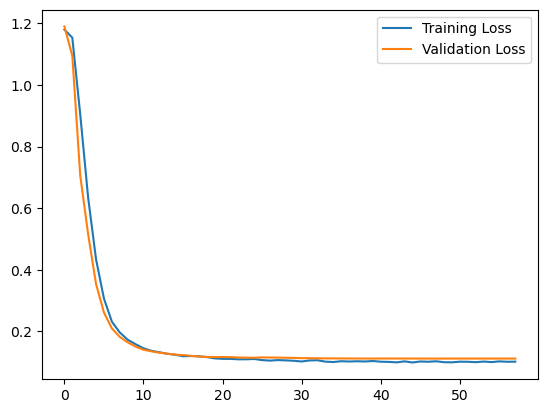

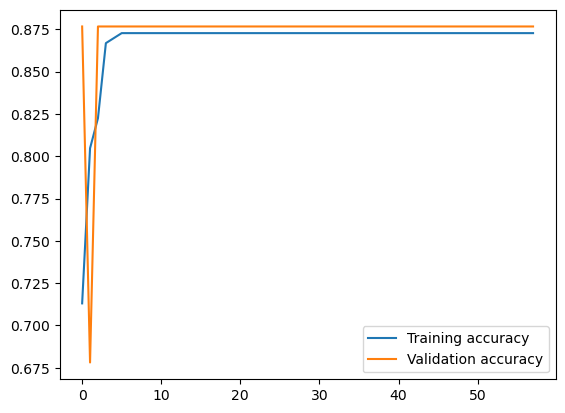

11/11 [==============================] - 0s 2ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       295 |         0 |
+-----------+-----------+
|        43 |         0 |
+-----------+-----------+
0.5
0.8752069373275522


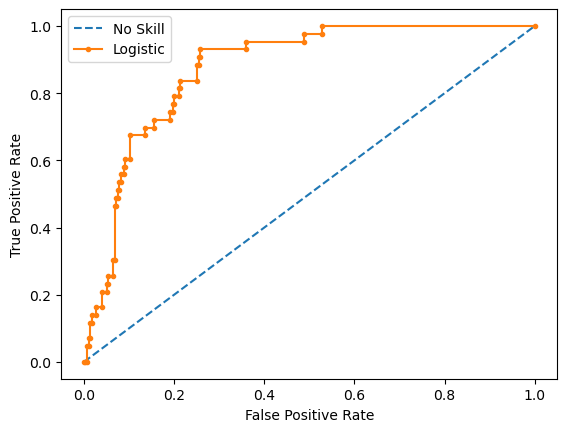

5/5 [==============================] - 0s 3ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       128 |         0 |
+-----------+-----------+
|        18 |         0 |
+-----------+-----------+
0.5
0.7152777777777777


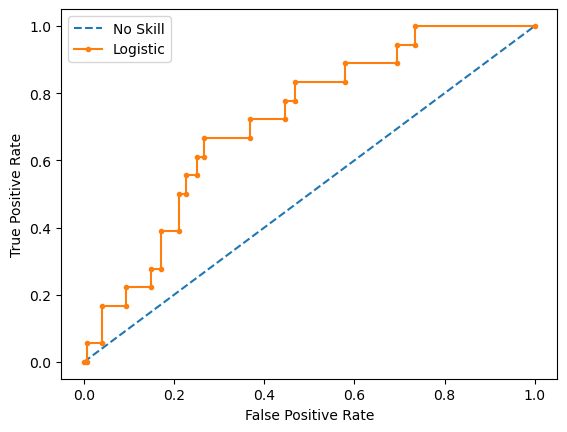

7/7 [==============================] - 0s 2ms/step
f1 score:  0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+
0.5
0.6050861706599412


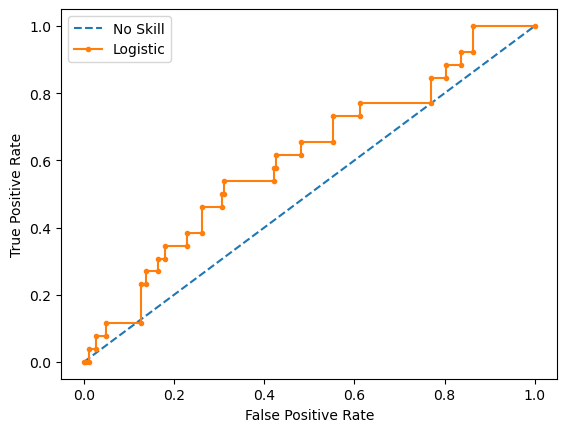

In [794]:
history_plotter(history_3)
auc_train, f1_train = results(model_3, X_train_pp, y_train)
auc_val, f1_val = results(model_3, X_val_pp, y_val)
auc_test, f1_test = results(model_3, X_test_pp, y_test)
winsound.Beep(1000, 1000)

In [ ]:
# (50, 50, 1)
# lambda = 0.01
# l1 0.1: all 0s
# l2 0.1: all 0s
# l1 0.01: all 0s
# l2 0.01: all 0s
# l1 0.001: all 0s
# l2 0.001: all 0s
# l1 0.0001: all 0s
# l2 0.0001: close to random guessing

# lambda = 0.001
# l1 0.1: all 0s
# l2 0.1: almost all 0s
# l1 0.01: all 0s
# l2 0.01: almost all 0s
# l1 0.001: all 0s
# l2 0.001: almost all 0s
# l1 0.0001: all 0s
# l2 0.0001: all 0s